In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import missingno as msno
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR
import torch.nn.functional as F
from pmdarima import auto_arima
#sns.set()

%matplotlib inline

In [2]:
# !pip install pmdarima

1. initialize data
- drop MAR,MCAR missing value
- fill MNAR missing value
- type convert(date,price,etc)
- drop outliers
2. describe data
3. time series analysis
4. feature engineering
- multicollinearity
- one hot encode
5. quick random forest: see the important features
6. tune paremeters
7. NN

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir('/content/drive/MyDrive/ADS/DS24spring-Final-Project/DS24spring-Final-Project-main')

# Data Cleaning and Exploratory Analysis

In [5]:
df2024_1=pd.read_csv('df2024_1.csv')

In [6]:
#select the number columns
numeric_df = df2024_1.select_dtypes(include=[np.number])

Get Correlation between different variables

In [7]:
corr = numeric_df.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)

<Axes: >

Plot all Neighbourhood Group

In [8]:
# sns.countplot(x='neighbourhood_group', data=df2024_1, palette="plasma")
# fig = plt.gcf()
# fig.set_size_inches(10,10)
# plt.title('Neighbourhood Group')

Neighbourhood

Text(0.5, 1.0, 'Neighbourhood')

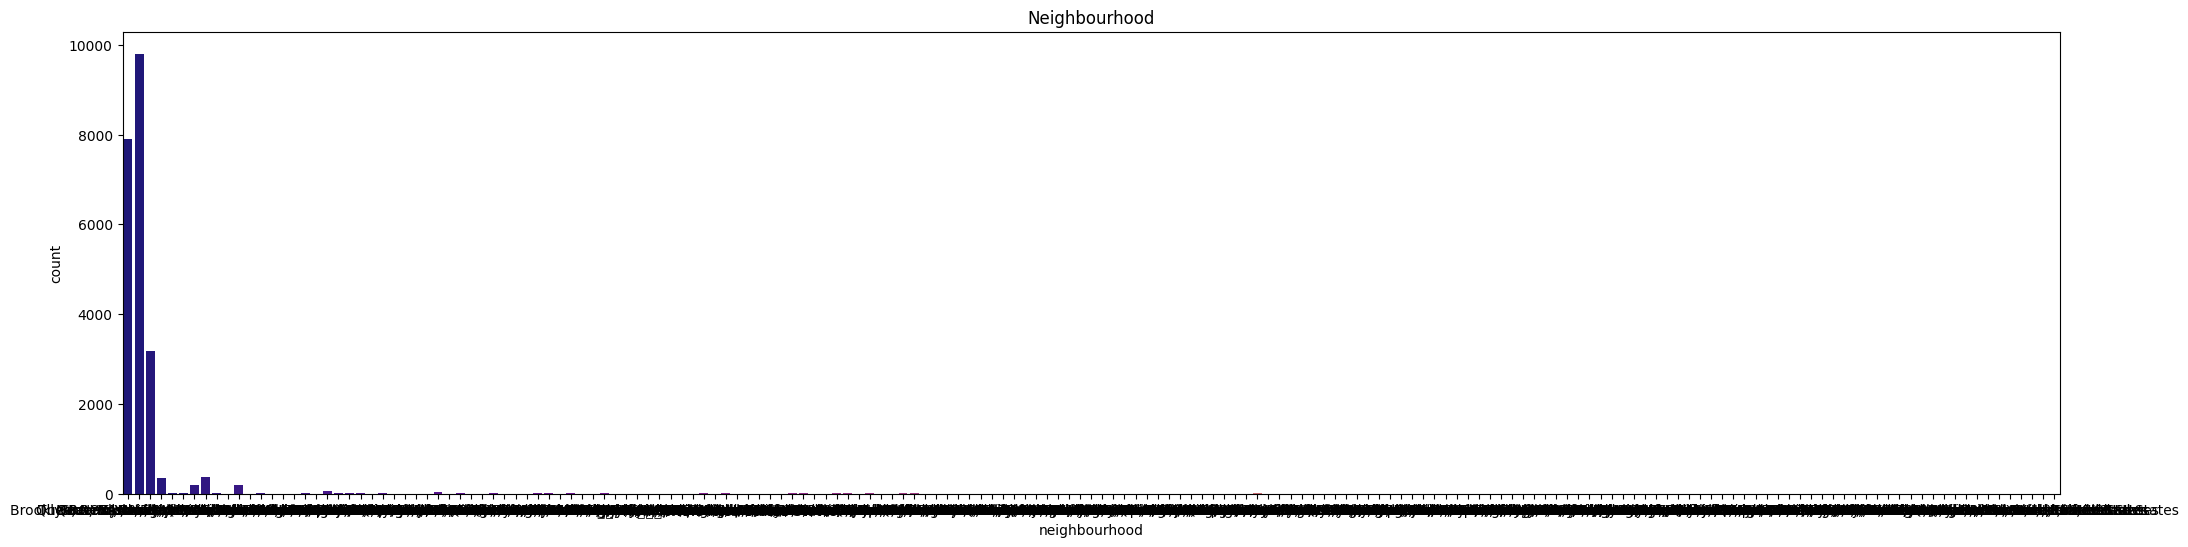

In [9]:
sns.countplot(x='neighbourhood', data=df2024_1, palette="plasma")
fig = plt.gcf()
fig.set_size_inches(25,6)
plt.title('Neighbourhood')


In [10]:
df2024_1['neighbourhood'] = df2024_1['neighbourhood'].astype(str)

Room Type

Text(0.5, 1.0, 'Restaurants delivering online or Not')

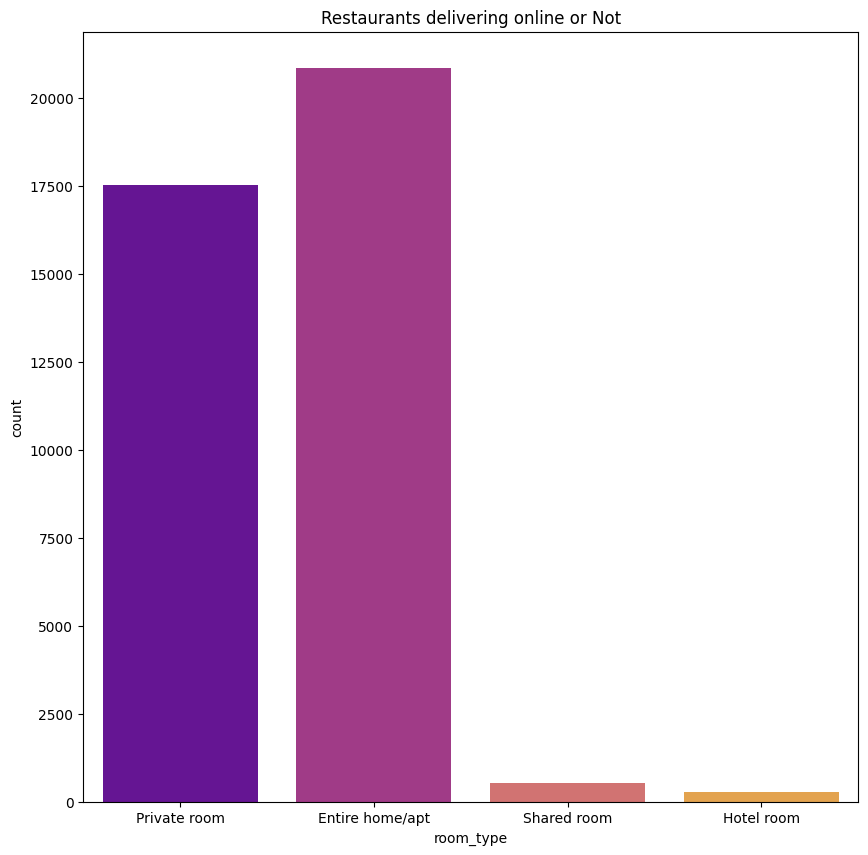

In [11]:
#Restaurants delivering Online or not
sns.countplot(x='room_type', data=df2024_1, palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Restaurants delivering online or Not')

Relation between neighbourgroup and Availability of Room¶


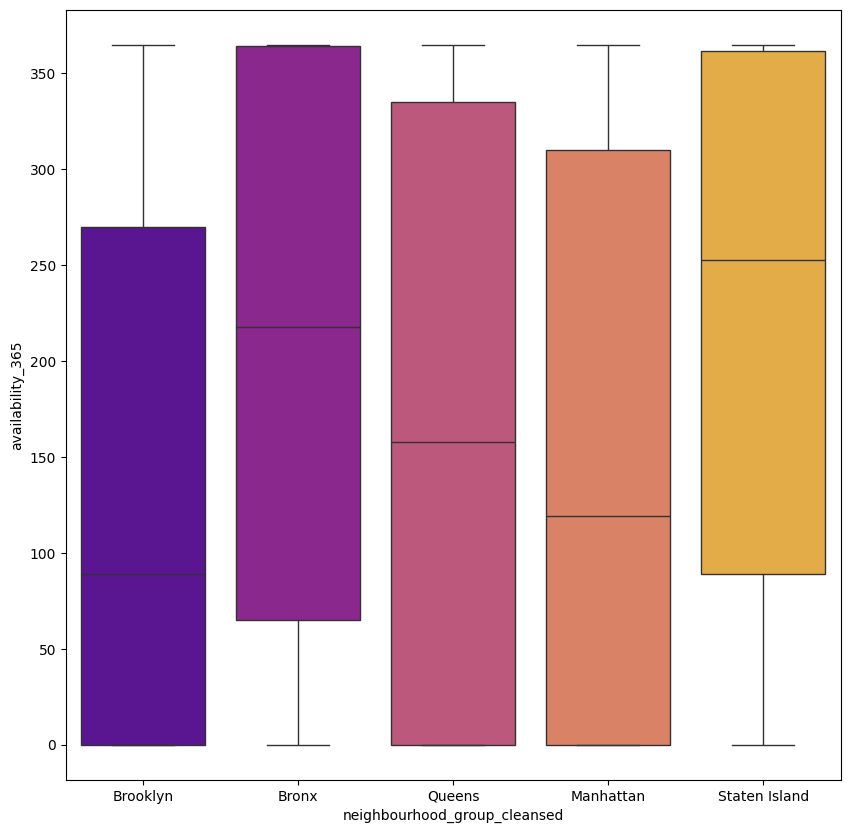

In [12]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=df2024_1, x='neighbourhood_group_cleansed',y='availability_365',palette='plasma')
plt.show()

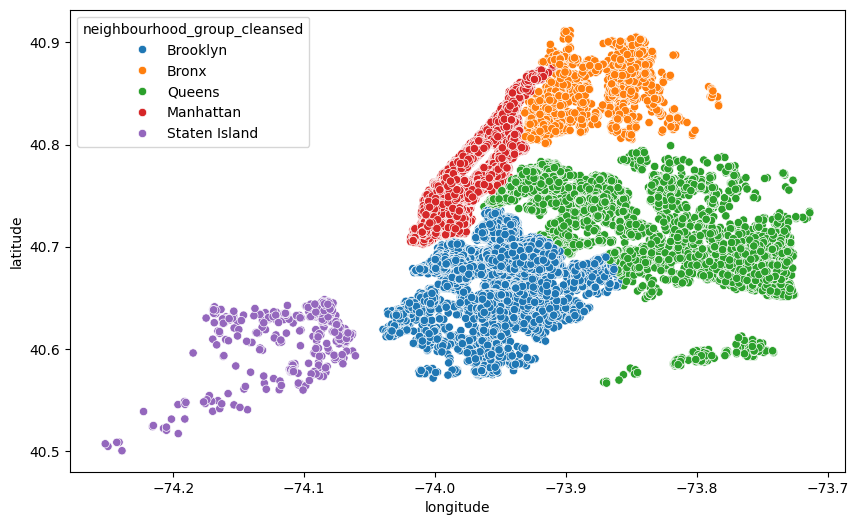

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2024_1['longitude'], y=df2024_1['latitude'], hue=df2024_1['neighbourhood_group_cleansed'])
plt.show()

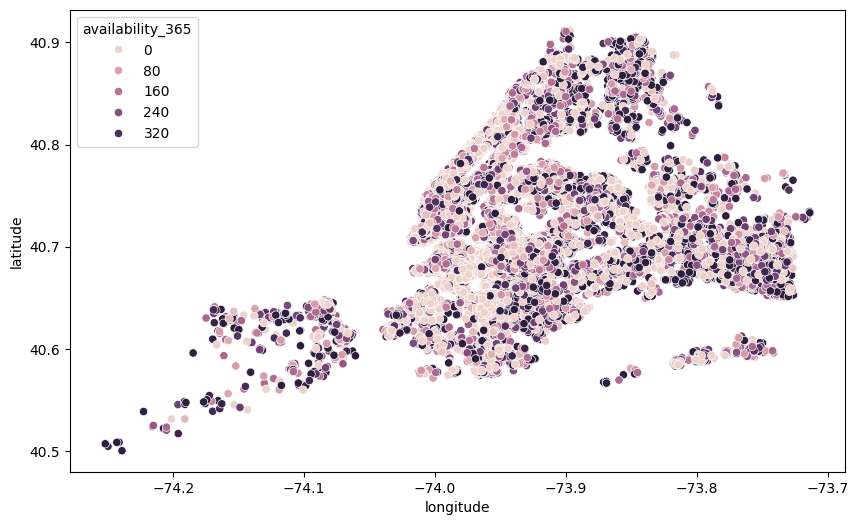

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2024_1['longitude'], y=df2024_1['latitude'], hue=df2024_1['availability_365'])
plt.show()

In [15]:
df2024_1.drop(['id', 'listing_url', 'scrape_id','source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name','host_location', 'host_about','host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications', 'neighbourhood','latitude','neighbourhood_group_cleansed','calendar_last_scraped',
       'longitude','license'],axis=1,inplace=True)

In [16]:
df2024_1.dtypes

last_scraped                                     object
host_since                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                             object
host_is_superhost                                object
host_has_profile_pic                             object
host_identity_verified                           object
neighbourhood_cleansed                           object
property_type                                    object
room_type                                        object
accommodates                                      int64
bathrooms                                       float64
bathrooms_text                                   object
bedrooms                                        float64
beds                                            float64
amenities                                        object
price                                           

In [17]:
df2024_1.describe()

accommodates     bathrooms      bedrooms          beds  minimum_nights  \
count  39202.000000  24335.000000  33011.000000  24222.000000    39202.000000   
mean       2.848860      1.202979      1.403532      1.681736       29.634432   
std        2.029674      0.556281      0.953565      1.254421       30.172981   
min        1.000000      0.000000      0.000000      0.000000        1.000000   
25%        2.000000      1.000000      1.000000      1.000000       30.000000   
50%        2.000000      1.000000      1.000000      1.000000       30.000000   
75%        4.000000      1.000000      2.000000      2.000000       30.000000   
max       16.000000     15.500000     26.000000     42.000000     1250.000000   

       maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
count    3.920200e+04            39200.000000            39200.000000   
mean     5.640459e+04               29.583495               37.791480   
std      1.084709e+07               32.040758               60.007764   
min      1.000000e+00                1.000000                1.000000   
25%      1.500000e+02               30.000000               30.000000   
50%      3.650000e+02               30.000000               30.000000   
75%      1.125000e+03               30.000000               30.000000   
max      2.147484e+09             1250.000000             1250.000000   

       minimum_maximum_nights  maximum_maximum_nights  ...  \
count            3.920000e+04            3.920000e+04  ...   
mean             7.686786e+05            1.700019e+06  ...   
std              4.057712e+07            6.036737e+07  ...   
min              1.000000e+00            1.000000e+00  ...   
25%              3.650000e+02            3.650000e+02  ...   
50%              1.125000e+03            1.125000e+03  ...   
75%              1.125000e+03            1.125000e+03  ...   
max              2.147484e+09            2.147484e+09  ...   

       review_scores_cleanliness  review_scores_checkin  \
count               27713.000000           27698.000000   
mean                    4.629591               4.814092   
std                     0.553984               0.420550   
min                     0.000000               0.000000   
25%                     4.500000               4.800000   
50%                     4.800000               4.940000   
75%                     5.000000               5.000000   
max                     5.000000               5.000000   

       review_scores_communication  review_scores_location  \
count                 27708.000000            27696.000000   
mean                      4.808529                4.727991   
std                       0.448769                0.418802   
min                       0.000000                0.000000   
25%                       4.800000                4.630000   
50%                       4.960000                4.840000   
75%                       5.000000                5.000000   
max                       5.000000                5.000000   

       review_scores_value  calculated_host_listings_count  \
count         27697.000000                    39202.000000   
mean              4.624456                       46.842661   
std               0.518733                      146.693303   
min               0.000000                        1.000000   
25%               4.510000                        1.000000   
50%               4.760000                        1.000000   
75%               4.930000                        6.000000   
max               5.000000                      827.000000   

       calculated_host_listings_count_entire_homes  \
count                                 39202.000000   
mean                                     24.227565   
std                                     120.567818   
min                                       0.000000   
25%                                       0.000000   
50%                                       1.000000   
75%                             

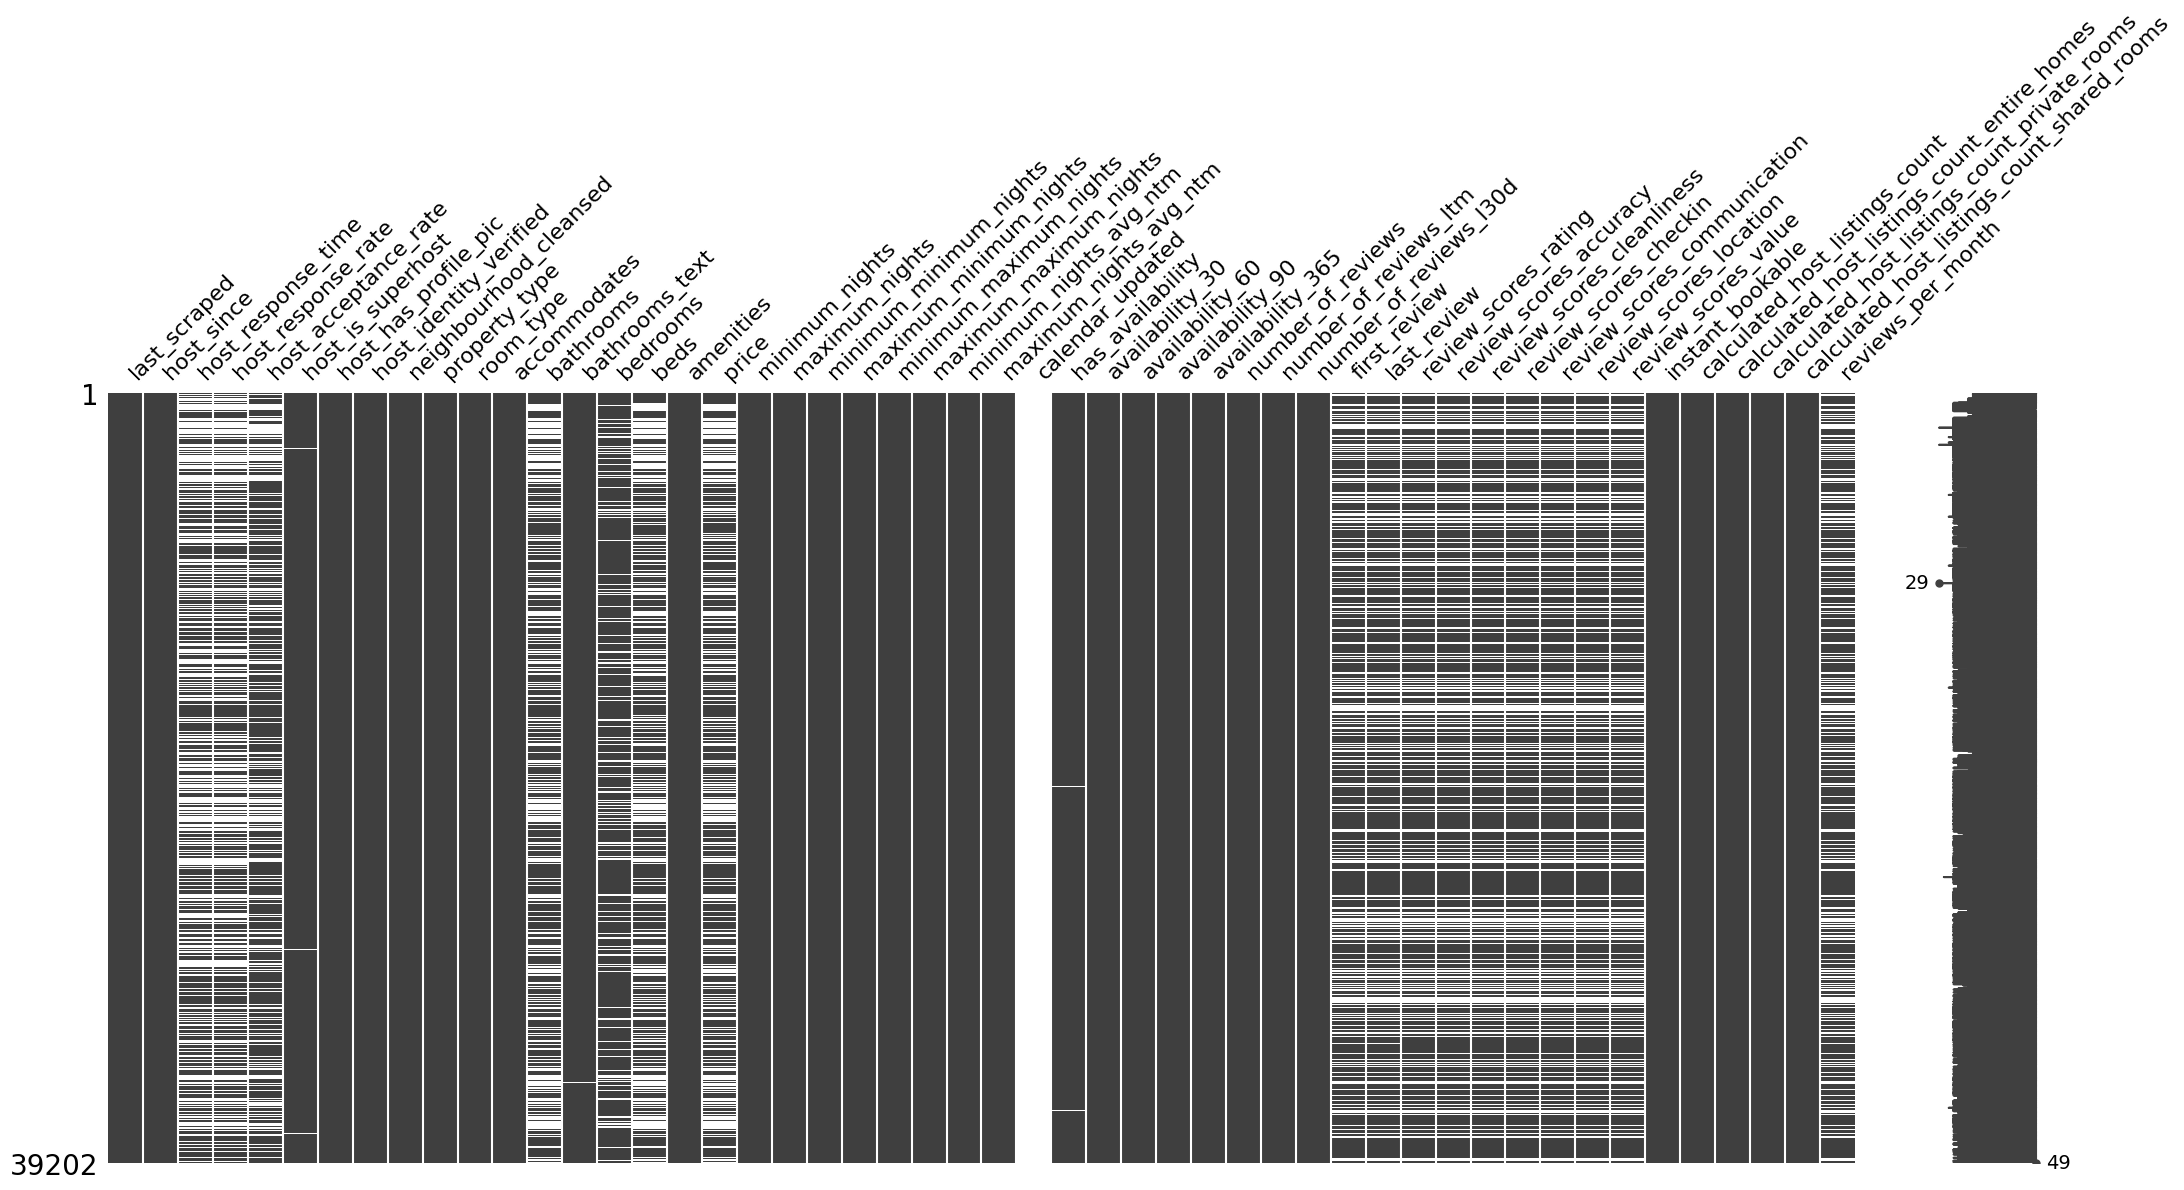

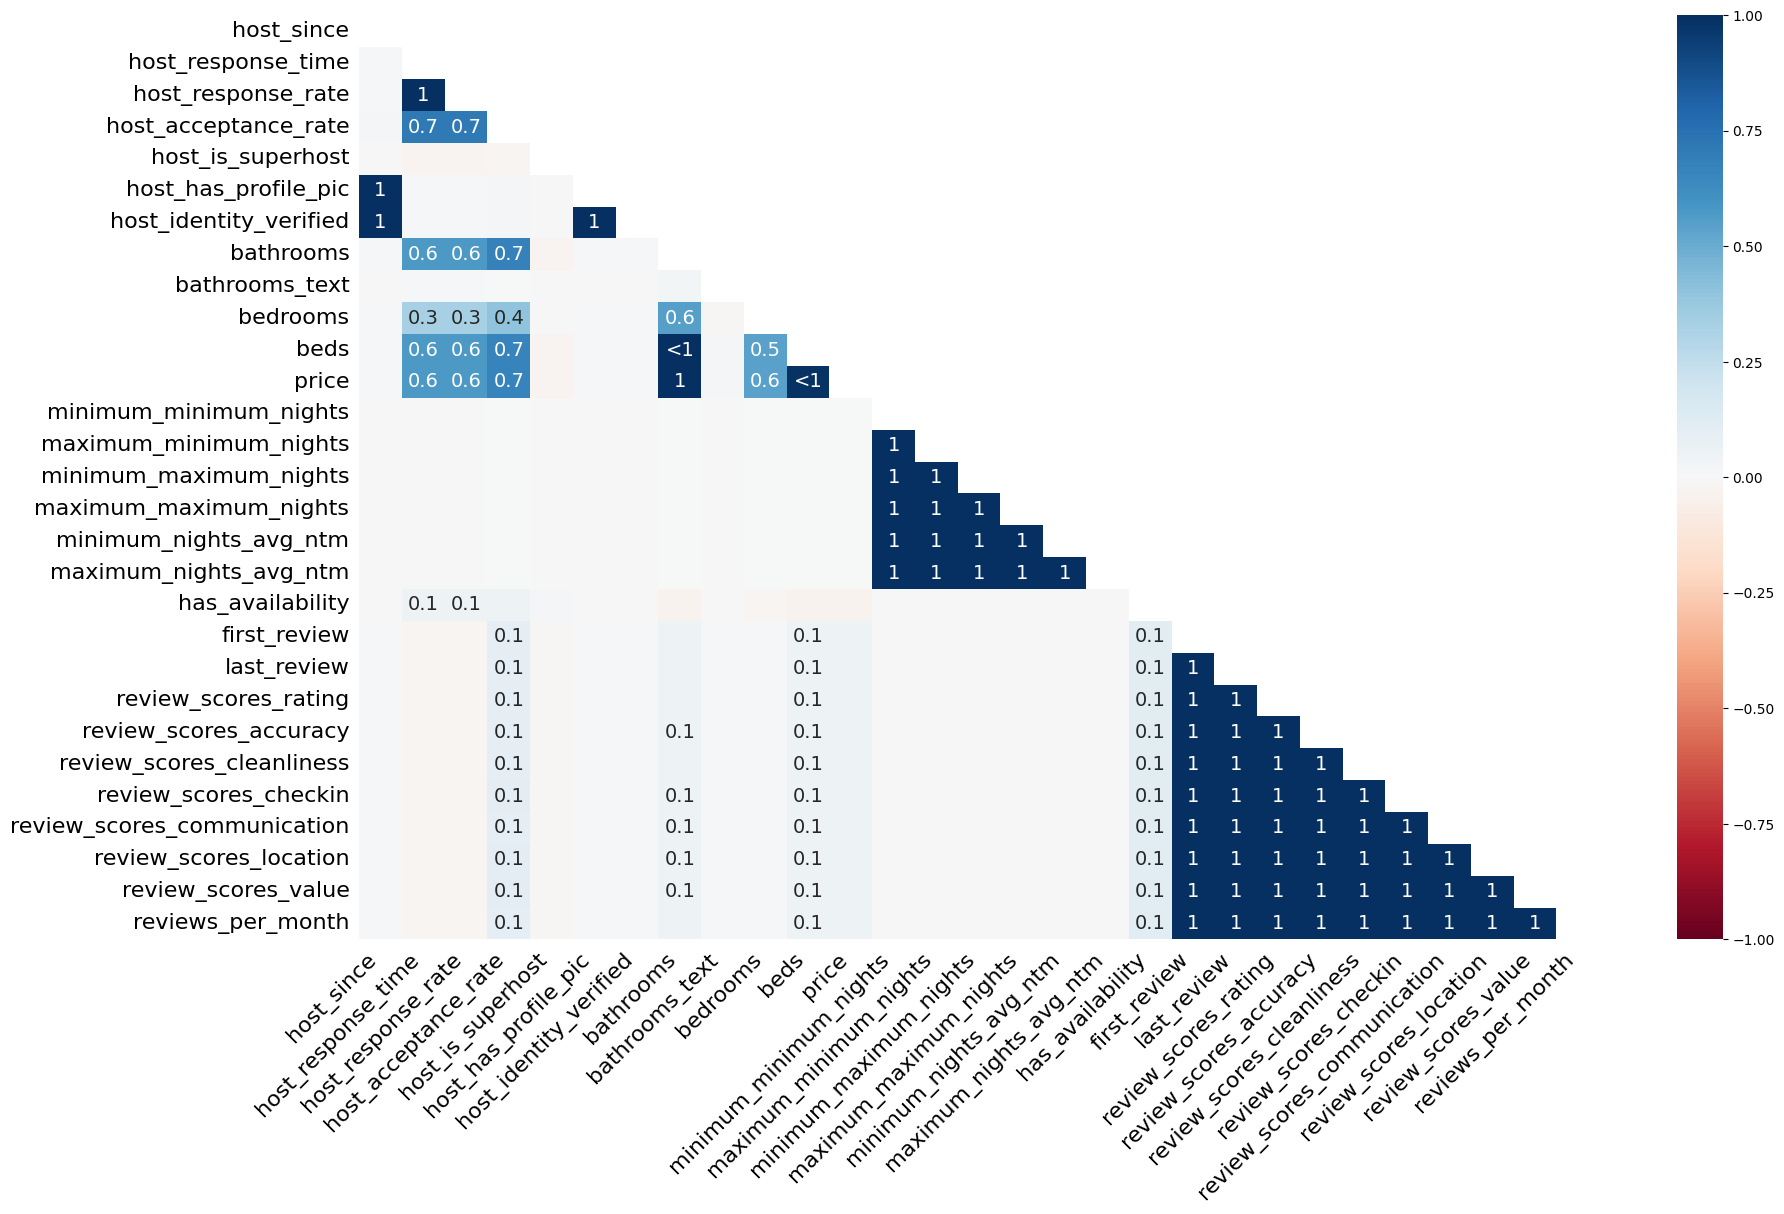

In [18]:
# Visualize the missingness matrix
msno.matrix(df2024_1)
plt.show()

# Heatmap of missingness correlation
msno.heatmap(df2024_1)
plt.show()

In [19]:
# drop missing values
columns_to_check = ['host_since', 'host_is_superhost', 'has_availability', 'calendar_updated', 'bathrooms_text','price']
threshold = 0.7  # 70% threshold for missing values

for col in columns_to_check:
    missing_proportion = df2024_1[col].isna().mean()  # Proportion of missing values
    if missing_proportion > threshold:
        # Drop the column
        df2024_1.drop(col, axis=1, inplace=True)
    elif missing_proportion > 0:
        # Drop rows with missing values in this column
        df2024_1 = df2024_1.dropna(subset=[col])

In [20]:

df2024_1.price.describe()

count       23914
unique        913
top       $100.00
freq          645
Name: price, dtype: object

In [21]:
# fill missing values
# numeric columns
numeric_cols = df2024_1.select_dtypes(include=['number']).columns

# Then identify those numeric columns that have missing values
numeric_cols_with_missing = numeric_cols[df2024_1[numeric_cols].isna().any(axis=0)]

# Now iterate over those columns and print min/max if the minimum is not zero, then fill NaN with 0
for col in numeric_cols_with_missing:
    if df2024_1[col].min(skipna=True) != 0:
        print(f"{col} - Min: {df2024_1[col].min()}, Max: {df2024_1[col].max()}")
        df2024_1[col].fillna(0, inplace=True)

minimum_minimum_nights - Min: 1.0, Max: 500.0
maximum_minimum_nights - Min: 1.0, Max: 1000.0
minimum_maximum_nights - Min: 1.0, Max: 2147483647.0
maximum_maximum_nights - Min: 2.0, Max: 2147483647.0
minimum_nights_avg_ntm - Min: 1.0, Max: 956.8
maximum_nights_avg_ntm - Min: 2.0, Max: 2147483647.0
review_scores_rating - Min: 1.0, Max: 5.0
review_scores_accuracy - Min: 1.0, Max: 5.0
review_scores_cleanliness - Min: 1.0, Max: 5.0
review_scores_checkin - Min: 1.0, Max: 5.0
review_scores_communication - Min: 1.0, Max: 5.0
review_scores_location - Min: 1.0, Max: 5.0
review_scores_value - Min: 1.0, Max: 5.0
reviews_per_month - Min: 0.01, Max: 78.25


In [22]:
# fill missing values
# review columns

# to Datetime
df2024_1['last_scraped'] = pd.to_datetime(df2024_1['last_scraped'])
for col in ['host_since', 'first_review', 'last_review']:
    # Ensure that the column is in datetime format
    df2024_1[col] = pd.to_datetime(df2024_1[col], errors='coerce')  # Use 'coerce' to handle any parsing errors


# for col in ['first_review', 'last_review', 'review_scores_rating',
#             'review_scores_accuracy', 'review_scores_cleanliness',
#             'review_scores_checkin', 'review_scores_communication',
#             'review_scores_location', 'review_scores_value']:

#     missing_col_name = col + '_missing'
#     df2024_1[missing_col_name] = df2024_1[col].isna().astype(int)

# For date columns, select a fill value and convert to days
date_fill_value = df2024_1['first_review'].min(skipna=True)
df2024_1['first_review'].fillna(date_fill_value, inplace=True)
df2024_1['last_review'].fillna(date_fill_value, inplace=True)

# Convert date column to number of days
df2024_1['days_since_first_review'] = (df2024_1['last_scraped'] - pd.to_datetime(df2024_1['first_review'])).dt.days
df2024_1['days_since_last_review'] = (df2024_1['last_scraped'] - pd.to_datetime(df2024_1['last_review'])).dt.days
df2024_1['days_since_host_since'] = (df2024_1['last_scraped'] - pd.to_datetime(df2024_1['host_since'])).dt.days
df2024_1['days_since_first_review'] = df2024_1['days_since_first_review'].astype(float)
df2024_1['days_since_last_review'] = df2024_1['days_since_last_review'].astype(float)
df2024_1['days_since_host_since'] = df2024_1['days_since_host_since'].astype(float)

# For rating columns, use neutral values to fill missing values
for score_col in ['review_scores_rating', 'review_scores_accuracy',
                  'review_scores_cleanliness', 'review_scores_checkin',
                  'review_scores_communication', 'review_scores_location',
                  'review_scores_value']:
    neutral_value = 2.5
    df2024_1[score_col].fillna(neutral_value, inplace=True)

df2024_1.drop(['last_scraped','first_review', 'last_review','host_since'],axis=1,inplace=True)

In [23]:
# string to float
df2024_1['host_acceptance_rate'] = df2024_1['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
df2024_1['host_response_rate'] = df2024_1['host_response_rate'].str.rstrip('%').astype('float') / 100.0

In [24]:
columns_to_convert = [
    'host_is_superhost',
    'host_has_profile_pic',
    'host_identity_verified',
    'has_availability',
    'instant_bookable'
]

# Assuming that 't' represents True and 'f' represents False in your dataset
bool_mapping = {'t': True, 'f': False}

for col in columns_to_convert:
    # Map the 't'/'f' values to True/False
    df2024_1[col] = df2024_1[col].map(bool_mapping)

In [25]:
# Remove both the dollar sign and commas, then convert to float
df2024_1['price'] = df2024_1['price'].replace('[\$,]', '', regex=True).astype(float)

In [26]:
missing_values_count = df2024_1.isna().sum()

# Filter and print only those columns that have non-zero missing values
non_zero_missing = missing_values_count[missing_values_count != 0]
print(non_zero_missing)

host_response_time      5466
host_response_rate      5466
host_acceptance_rate    1724
bedrooms                  46
beds                     114
dtype: int64


In [27]:
df2024_1[['host_response_rate','host_acceptance_rate','bedrooms','beds']].describe()

host_response_rate  host_acceptance_rate      bedrooms          beds
count        18448.000000          22190.000000  23868.000000  23800.000000
mean             0.940187              0.808767      1.374141      1.685210
std              0.176757              0.268407      0.966722      1.256933
min              0.000000              0.000000      0.000000      0.000000
25%              0.990000              0.730000      1.000000      1.000000
50%              1.000000              0.940000      1.000000      1.000000
75%              1.000000              1.000000      2.000000      2.000000
max              1.000000              1.000000     16.000000     42.000000

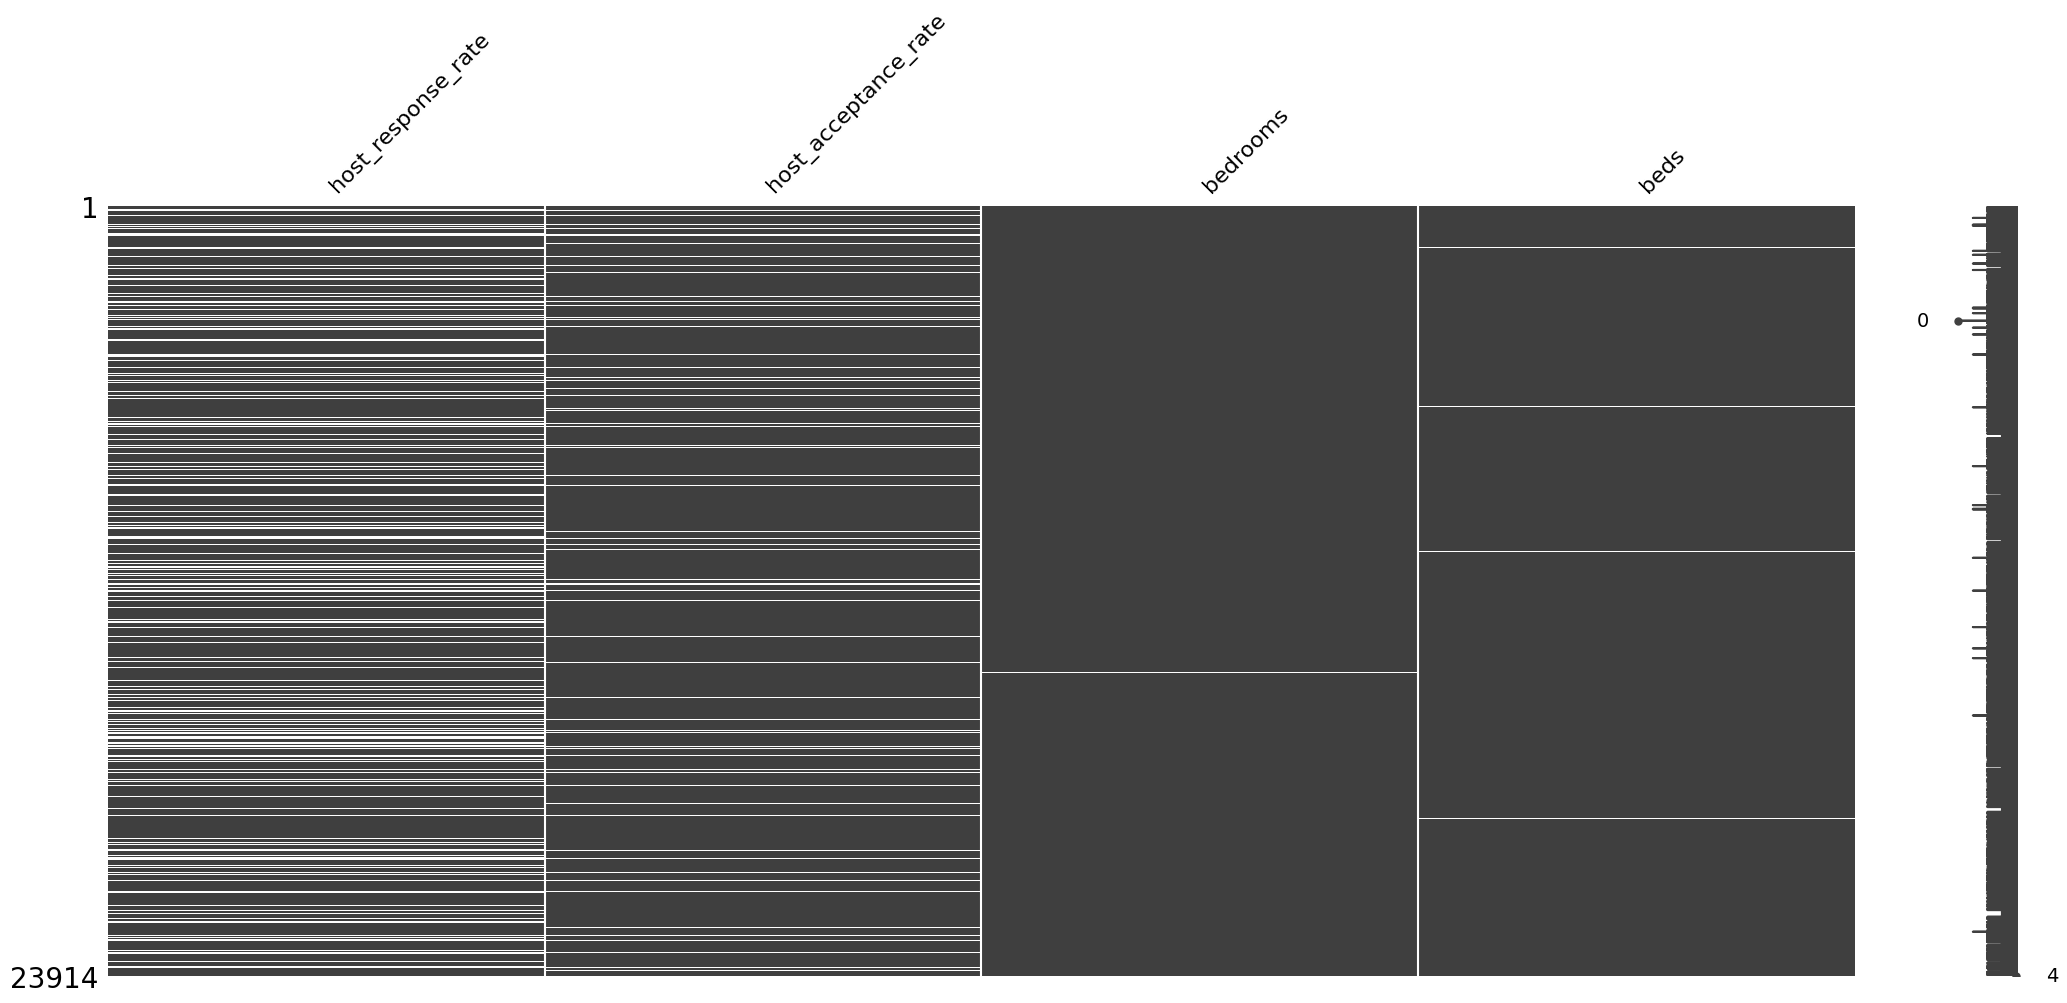

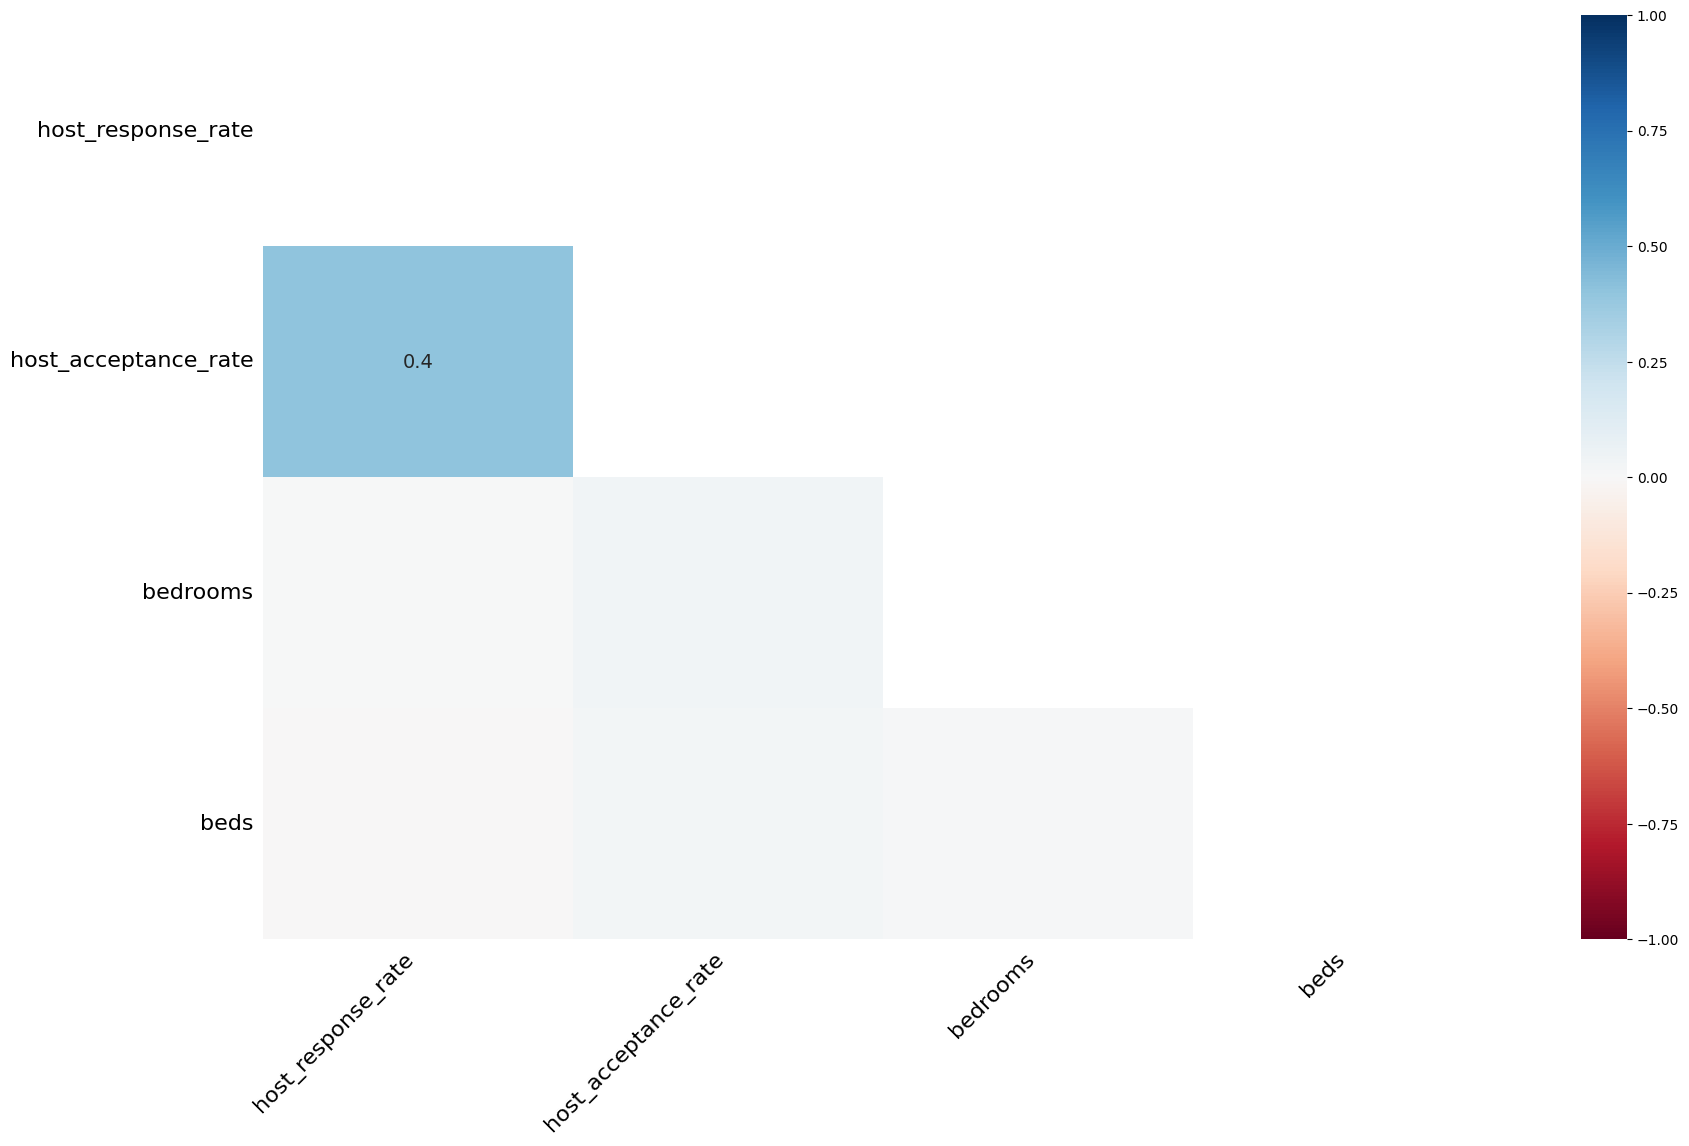

In [28]:
# Visualize the missingness matrix
msno.matrix(df2024_1[['host_response_rate','host_acceptance_rate','bedrooms','beds']])
plt.show()

# Heatmap of missingness correlation
msno.heatmap(df2024_1[['host_response_rate','host_acceptance_rate','bedrooms','beds']])
plt.show()

In [29]:
# delete rows which have missing values
df2024_1 = df2024_1.dropna(subset=['host_response_rate', 'host_acceptance_rate', 'bedrooms', 'beds'])

In [30]:
df2024_1.columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calc

# Time Series

df include last_review and price

In [31]:
df=pd.read_csv('Data/listings2024_01.csv')
df.dropna(inplace=True)

In [32]:
# Convert 'last_review' column to datetime type
df['last_review'] = pd.to_datetime(df['last_review'])

# Set 'last_review' as index
df.set_index('last_review', inplace=True)


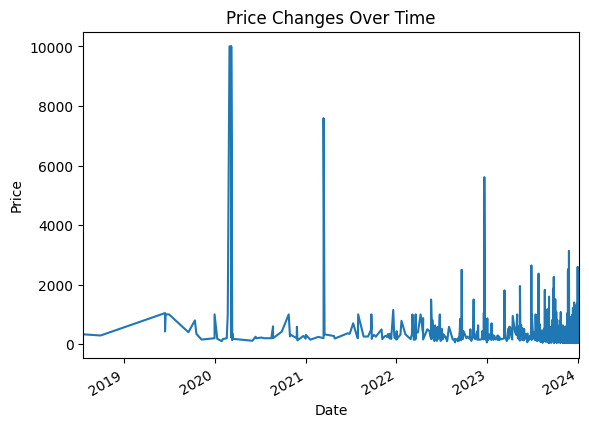

In [33]:
# Plot price changes over time
df['price'].plot()
plt.title('Price Changes Over Time')
plt.xlabel('Date')
plt.ylabel('Price')

# Set the range of the x-axis to the minimum and maximum dates of the dataset
plt.xlim(df.index.min(), df.index.max())

plt.show()



In [34]:
# Confirm whether 'last_review' is a column of DataFrame
if 'last_review' in df.columns:
    # If 'last_review' is a column, remove NaT by column
    df.dropna(subset=['last_review'], inplace=True)
    # Convert 'last_review' column to DatetimeIndex
    df['last_review'] = pd.to_datetime(df['last_review'])
    df.set_index('last_review', inplace=True)
else:
    # If 'last_review' is already an index
    df.index = pd.to_datetime(df.index)  # Make sure the index is of DatetimeIndex type
    df = df[~df.index.isna()]  # Delete rows with index NaT

# Aggregate duplicate date data
if df.index.duplicated().any():
    df = df.groupby(df.index).agg({'price': 'mean'})  # Aggregate using average of prices

# Try setting it to daily frequency
df = df.asfreq('D', method='pad')  # Use forward padding to handle missing dates

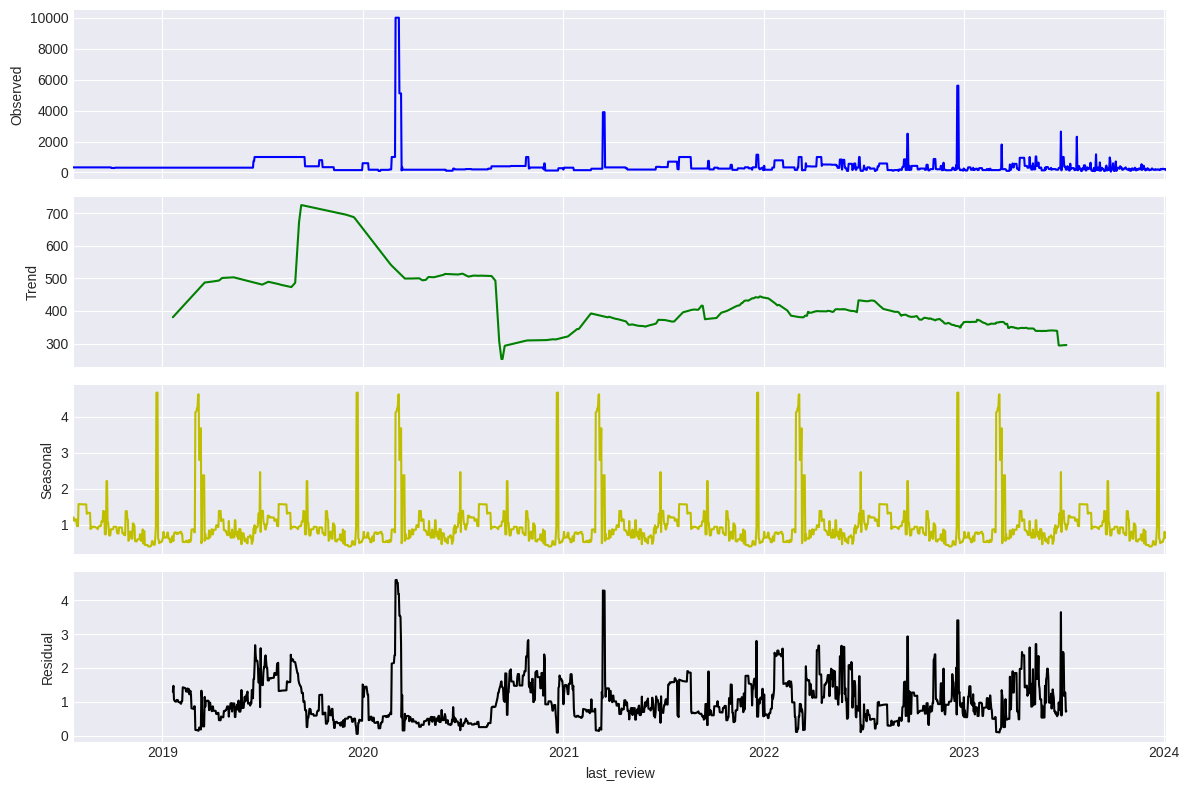

In [35]:
# Try a multiplicative model for seasonal decomposition
result = seasonal_decompose(df['price'], model='multiplicative', period=365)

# Draw an exploded diagram using the method
plt.style.use('seaborn-darkgrid')
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 8))

result.observed.plot(ax=axes[0], legend=False, color='b')
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False, color = 'y')
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()


In [36]:
auto_model = auto_arima(df['price'], seasonal=True, m=12, d=1, D=1,
                        max_p=3, max_q=3, max_P=3, max_Q=3,
                        trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=28.95 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=30452.437, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=29909.991, Time=2.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.70 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=30454.194, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=29676.726, Time=3.33 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=29546.499, Time=8.18 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=36.68 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=17.94 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=29553.351, Time=2.27 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=29548.247, Time=10.31 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=inf, Time=25.47 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=29546.188, Time=8.27 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=29676.415, Time=3.40 sec
 ARIMA(0,1,1)(3,1,1)[12]      

In [37]:
# Check for stationarity
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['price'])

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -9.482698
p-value: 0.000000


### Forecast for the next 180 days, based on data from 2012 to new date

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

model = SARIMAX(df['price'],
                order=(2, 0, 0),
                seasonal_order=(3, 1, 0, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit()
forecast_result = model_fit.get_forecast(steps=180)

forecast_values1 = forecast_result.predicted_mean

df['price'].plot(label='Actual', figsize=(14, 7))
forecast_values1.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [39]:
forecast_values1 = forecast_result.predicted_mean
forecast_ci1 = forecast_result.conf_int()

forecast_ci1['lower price'] = forecast_ci1.iloc[:, 0].clip(lower=0)
forecast_ci1['upper price'] = forecast_ci1.iloc[:, 1]

print("Forecasted Prices for Next 180 Days:")
print(forecast_values1)

print("\n95% Confidence Intervals for the Forecast:")
print(forecast_ci1)

plt.figure(figsize=(14, 7))
df['price'].plot(label='Actual', color='blue')
forecast_values1.plot(label='Forecast', color='red')
plt.fill_between(forecast_values1.index,
                 forecast_ci1['lower price'],
                 forecast_ci1['upper price'], color='pink', alpha=0.3)
plt.title('Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Forecasted Prices for Next 180 Days:
2024-01-06    135.203112
2024-01-07    174.280158
2024-01-08    246.325721
2024-01-09    169.501076
2024-01-10    161.944466
                 ...    
2024-06-29    208.291431
2024-06-30    185.253847
2024-07-01    210.475086
2024-07-02    193.246675
2024-07-03    158.899130
Freq: D, Name: predicted_mean, Length: 180, dtype: float64

95% Confidence Intervals for the Forecast:
            lower price  upper price
2024-01-06          0.0   933.854818
2024-01-07          0.0  1230.883690
2024-01-08          0.0  1459.176676
2024-01-09          0.0  1486.211699
2024-01-10          0.0  1550.603821
...                 ...          ...
2024-06-29          0.0  3366.421578
2024-06-30          0.0  3345.532707
2024-07-01          0.0  3372.344979
2024-07-02          0.0  3356.294842
2024-07-03          0.0  3322.819993

[180 rows x 2 columns]


### Forecast for the next 180 days, based on data from 2022 to new date

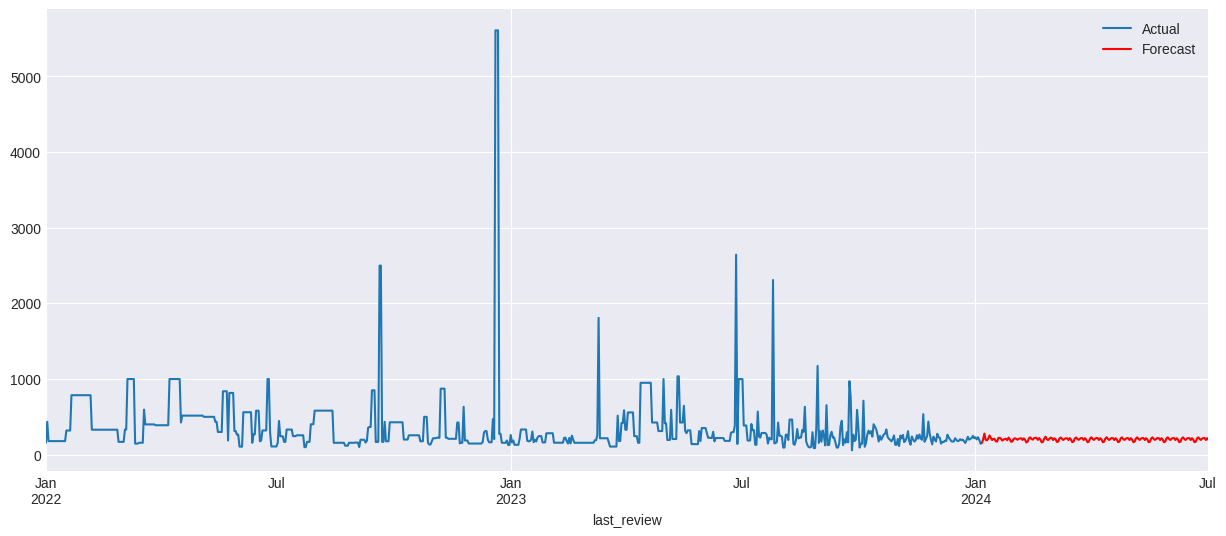

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

start_date = '2022-01'
end_date = df.index[-1]
mask = (df.index >= start_date) & (df.index <= end_date)
df_subset = df.loc[mask]

sarimax_model = SARIMAX(df_subset['price'],
                        order=(2, 0, 0),
                        seasonal_order=(3, 1, 0, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarimax_result = sarimax_model.fit()
last_known_date = df.index[-1]
forecast_steps = 180
forecast = sarimax_result.get_forecast(steps=forecast_steps)

forecast_values = forecast.predicted_mean

last_known_date = df_subset.index[-1]
forecast_dates = pd.date_range(start=last_known_date, periods=forecast_steps, freq='D')

forecast_series = pd.Series(forecast_values, index=forecast_dates)

df_subset['price'].plot(label='Actual', figsize=(15, 6))
forecast_series.plot(label='Forecast', color='red')
plt.legend()
plt.show()


Forecasted Prices for Next 180 Days:
2024-01-06    151.625331
2024-01-07    200.241354
2024-01-08    277.403802
2024-01-09    197.327374
2024-01-10    187.735205
                 ...    
2024-06-29    217.034744
2024-06-30    192.796017
2024-07-01    216.976841
2024-07-02    199.084544
2024-07-03    164.016870
Freq: D, Name: predicted_mean, Length: 180, dtype: float64

95% Confidence Intervals for the Forecast:
            lower price  upper price
2024-01-06          0.0   946.613844
2024-01-07          0.0  1128.934840
2024-01-08          0.0  1242.130461
2024-01-09          0.0  1172.217245
2024-01-10          0.0  1165.533119
...                 ...          ...
2024-06-29          0.0  1942.112635
2024-06-30          0.0  1917.875704
2024-07-01          0.0  1942.057045
2024-07-02          0.0  1924.164897
2024-07-03          0.0  1889.097266

[180 rows x 2 columns]


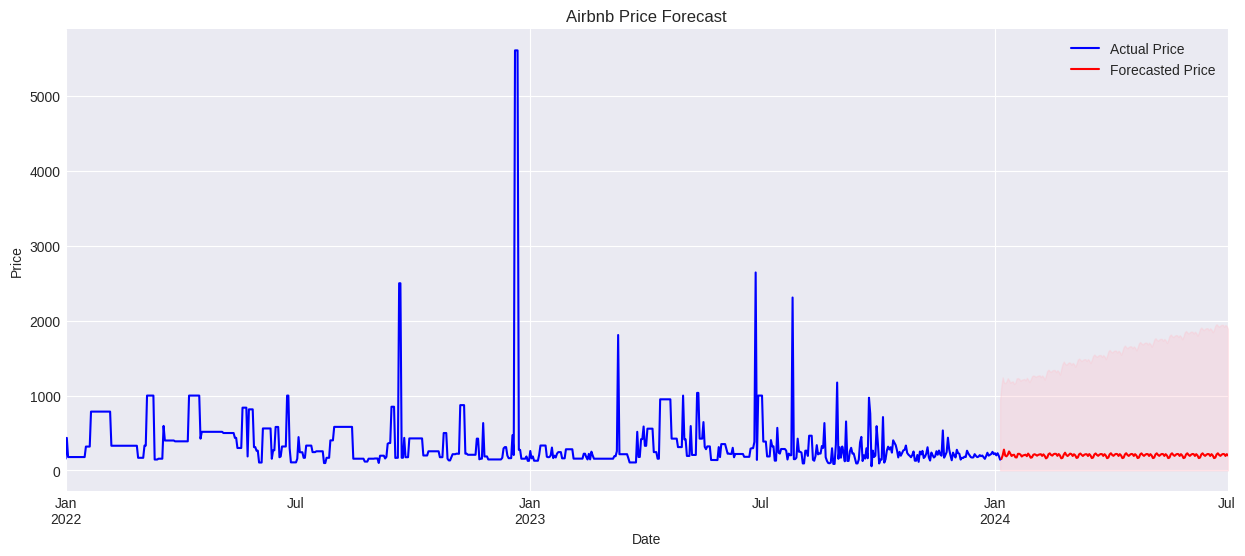

In [41]:
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_ci['lower price'] = forecast_ci.iloc[:, 0].clip(lower=0)
forecast_ci['upper price'] = forecast_ci.iloc[:, 1]

print("Forecasted Prices for Next 180 Days:")
print(forecast_values)

print("\n95% Confidence Intervals for the Forecast:")
print(forecast_ci)

last_known_date = df_subset.index[-1]
forecast_dates = pd.date_range(start=last_known_date, periods=forecast_steps, freq='D')
forecast_series = pd.Series(forecast_values, index=forecast_dates)

plt.figure(figsize=(15, 6))
df_subset['price'].plot(label='Actual Price', color='blue')
forecast_series.plot(label='Forecasted Price', color='red')
plt.fill_between(forecast_series.index,
                 forecast_ci['lower price'],
                 forecast_ci['upper price'], color='pink', alpha=0.3)
plt.title('Airbnb Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# Feature Engineering

## multicollinearity

In [42]:
review_score_columns = [
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]
df2024_1['review_score_mean'] = df2024_1[review_score_columns].mean(axis=1)
df2024_1.drop(review_score_columns,axis=1,inplace=True)

In [43]:
multicollinearity_drop_columns=[
    'maximum_nights_avg_ntm','availability_60','availability_90','calculated_host_listings_count','minimum_nights_avg_ntm','days_since_first_review','minimum_minimum_nights'
]
df2024_1.drop(multicollinearity_drop_columns,axis=1,inplace=True)

In [44]:
# drop outliers
numeric_cols = df2024_1.select_dtypes(include=['number'])
isolation_forest = IsolationForest(random_state = 88)

# rf_data_copy = df2024_1.copy()

# Predict the outliers, where -1 indicates an anomaly
A = isolation_forest.fit_predict(numeric_cols)

# Retrieve the indices of the rows where anomalies are located
outlier_indices = np.where(A == -1)[0]
# Drop the outliers from the dataframe
numeric_cols = numeric_cols.drop(numeric_cols.index[outlier_indices])

In [45]:
numeric_cols=numeric_cols[numeric_cols.price<100000]

In [46]:
numeric_cols.shape

(16406, 24)

In [47]:
# numeric_cols = df2024_1.select_dtypes(include=['number'])
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
# calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_cols.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_cols.values, i) for i in range(numeric_cols.shape[1])]

In [48]:
has_multiL_problem=vif_data[vif_data['VIF']>=10]
display(has_multiL_problem)

feature        VIF
0       host_response_rate  37.204860
1     host_acceptance_rate  19.016753
21  days_since_last_review  11.746381
23       review_score_mean  33.729203

## Encode Labels

In [49]:
# Calculate the length of each list of amenities as a new feature
df2024_1['amenities_count'] = df2024_1['amenities'].apply(lambda x: len(eval(x)))

In [50]:
# from sklearn.preprocessing import MultiLabelBinarizer


# df2024_1['amenities'] = df2024_1['amenities'].apply(eval)


# mlb = MultiLabelBinarizer()
# amenities_encoded = mlb.fit_transform(df2024_1['amenities'])
# amenities_df = pd.DataFrame(amenities_encoded, columns=mlb.classes_, index=df2024_1.index)


# df = pd.concat([df2024_1, amenities_df], axis=1)


df2024_1.drop('amenities', axis=1, inplace=True)

In [51]:
label_selected_cols = [
  'host_response_time',
  'bathrooms_text'
 ]
for col in df2024_1.columns:
    if col in label_selected_cols:
        label_encoder = LabelEncoder()
        df2024_1[col]=df2024_1[col].fillna('Missing')
        df2024_1[col + '_LabelEncoded'] = label_encoder.fit_transform(df2024_1[col])
        df2024_1 = df2024_1.drop(columns=[col])

In [52]:
label_selected_cols = [
  'neighbourhood_cleansed',
  'property_type',
  'room_type'
 ]
# 1. Thresholds for calculating median and average house prices
quantiles = df2024_1['price'].quantile([0.25, 0.75])
mean_price = df2024_1['price'].mean()
median_price = df2024_1['price'].median()

# 2. Create Boolean column
df2024_1['expensive_area'] = df2024_1.groupby('neighbourhood_cleansed')['price'].transform(lambda x: x.median() > quantiles[0.75])
df2024_1['cheap_area'] = df2024_1.groupby('neighbourhood_cleansed')['price'].transform(lambda x: x.median() < quantiles[0.25])
df2024_1['expensive_property_type'] = df2024_1.groupby('property_type')['price'].transform(lambda x: x.median() > quantiles[0.75])
df2024_1['cheap_property_type'] = df2024_1.groupby('property_type')['price'].transform(lambda x: x.median() < quantiles[0.25])
df2024_1['expensive_room_type'] = df2024_1.groupby('room_type')['price'].transform(lambda x: x.median() > quantiles[0.75])
df2024_1['cheap_room_type'] = df2024_1.groupby('room_type')['price'].transform(lambda x: x.median() < quantiles[0.25])

# 3. One-hot encoding
df2024_1 = pd.get_dummies(df2024_1, columns=label_selected_cols)

# 4. Delete columns whose number of True is less than 5
for col in df2024_1.columns:
    if df2024_1[col].dtype == 'uint8' and df2024_1[col].sum() < 10:
        df2024_1.drop(col, axis=1, inplace=True)

## Outlies

In [53]:
# drop outliers
isolation_forest = IsolationForest(random_state = 88)

# rf_data_copy = df2024_1.copy()

# Predict the outliers, where -1 indicates an anomaly
A = isolation_forest.fit_predict(df2024_1)

# Retrieve the indices of the rows where anomalies are located
outlier_indices = np.where(A == -1)[0]
# Drop the outliers from the dataframe
df2024_1 = df2024_1.drop(df2024_1.index[outlier_indices])

In [54]:
df2024_1=df2024_1[df2024_1.price<100000]

In [55]:
df2024_1.shape

(18042, 314)

# Models

- Model testing without feature selection: (model: xg_reg, rf)
- Model after feature selection using random forest (model: best_rf_XGB, best_rf_rf)
- Model after feature selection using XGBoost (model: best_xgb_XGB, best_xgb_rf)
- Model after PCA dimensionality reduction (model: best_pca_XGB, best_pca_rf)
- NN



## Standardization

In [56]:
# X = df2024_1.drop(['price'],axis=1)
features = df2024_1.drop(['price'], axis=1)
scaler = preprocessing.StandardScaler().fit(features)

# Use the fitted scaler to transform the data
X_scaled = scaler.transform(features)

# Create a new DataFrame with the transformed data and original column names
X = pd.DataFrame(X_scaled, columns=features.columns)
y = np.log(df2024_1[['price']])
# y = df2024_1[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [57]:
from sklearn.metrics import mean_absolute_percentage_error

def scores(X_train, X_test, y_train, y_test, model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # R2
    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    # MSE RMSE
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)

    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    # MAPE
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    print(f"Train R2 score: {train_score}, Test R2 score {test_score}")
    print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    print(f"Train MAPE: {train_mape}, Test MAPE: {test_mape}")

In [58]:
def n_r2score_plot(estimators,mod,X_train, X_test, y_train, y_test):
#     estimators: a list of number
#     mod: 0-XGBoost, 1 - random forest

    train_scores = []
    test_scores = []
    for n in estimators:
        if mod==1:
            model = RandomForestRegressor(n_estimators=n, random_state=42,n_jobs=-1)
        else:
            model = xgb.XGBRegressor(n_estimators=n, random_state=42,n_jobs=-1)
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        train_scores.append(r2_score(y_train, train_pred))
        test_scores.append(r2_score(y_test, test_pred))

    plt.figure(figsize=(10, 6))
    plt.plot(estimators, train_scores, label='Training R2 Score')
    plt.plot(estimators, test_scores, label='Testing R2 Score')
    plt.xlabel('Number of Estimators')
    plt.ylabel('R2 Score')
    plt.title('R2 Score vs. Number of Estimators')
    plt.legend()
    plt.grid(True)
    plt.show()

In [59]:
def grid_tune(param_grid, mod, ver, X_train, y_train):
    if mod == 0:
        model = xgb.XGBRegressor(random_state=42)
    else:
        model = RandomForestRegressor(random_state=42)

    #Initialize the grid search object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring='r2', cv=5, verbose=ver, n_jobs=-1)

    # Perform grid search
    grid_search.fit(X_train, y_train)

    # Print the optimal parameters and corresponding evaluation scores
    print("Best parameters found: ", grid_search.best_params_)
    print("Best R2 Score: ", grid_search.best_score_)

    return grid_search.best_estimator_

In [60]:
def feature_importance_ranking(model, columns):
    feature_importances = model.feature_importances_

    #Convert feature importance to DataFrame for easy plotting
    features_df = pd.DataFrame({'Features': columns, 'Importance Score': feature_importances})
    features_df = features_df.sort_values(by='Importance Score', ascending=False)

    # Draw feature importance bar chart
    plt.figure(figsize=(50,50))
    sns.barplot(x='Importance Score', y='Features', data=features_df)
    plt.title(f'Feature Importances')
    plt.show()

## Baseline model - XGBoost

In [61]:
xg_reg = xgb.XGBRegressor(random_state=42)
xg_reg.fit(X_train, y_train)

scores(X_train,X_test,y_train,y_test,xg_reg)

Train R2 score: 0.8943535034074747, Test R2 score 0.7929831949642622
Train MSE: 0.06571374046171408, Test MSE: 0.13394795715118368
Train RMSE: 0.2563469142816314, Test RMSE: 0.36598901233668707
Train MAPE: 0.038615142049466006, Test MAPE: 0.053896513606461145


## Baseline model - random forest

In [62]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

scores(X_train,X_test,y_train,y_test,rf)

Train R2 score: 0.969425091323932, Test R2 score 0.7897904263349127
Train MSE: 0.01901806191575975, Test MSE: 0.13601380313641145
Train RMSE: 0.137905989412207, Test RMSE: 0.36880049232127043
Train MAPE: 0.018996956249885552, Test MAPE: 0.05271819157880829


When the $R^2$ score on the training data is significantly higher than the $R^2$ score on the test data, it indicates that the model is overfitting.

## feature selection-RF

In [63]:
#Print feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Select features with higher than average importance scores
sfm = SelectFromModel(rf, threshold='median', prefit=True)
X_train_rf_selected = sfm.transform(X_train)
X_test_rf_selected = sfm.transform(X_test)

In [64]:
# Get the Boolean mask of the selected feature
selected_mask = sfm.get_support()

#Print the selected feature name
selected_features = X_train.columns[selected_mask]
print("Selected features:", selected_features)

Selected features: Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       ...
       'property_type_Room in aparthotel',
       'property_type_Room in boutique hotel', 'property_type_Room in hotel',
       'property_type_Shared room in home',
       'property_type_Shared room in loft',
       'property_type_Shared room in rental unit', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object', length=157)


### model-XGBoost

In [65]:
#Initialize XGBoost regression model
xg_reg_rf_features = xgb.XGBRegressor(random_state=42)
xg_reg_rf_features.fit(X_train_rf_selected, y_train)
scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,xg_reg_rf_features)

Train R2 score: 0.9091036780801113, Test R2 score 0.7969816792510047
Train MSE: 0.05653890569231228, Test MSE: 0.13136078167130993
Train RMSE: 0.2377791111353398, Test RMSE: 0.3624372796378843
Train MAPE: 0.03616707115940416, Test MAPE: 0.05288257501953279


In [66]:
n_r2score_plot(range(1,302,50),0,X_train_rf_selected,X_test_rf_selected,y_train,y_test)

In [67]:
# Set the parameter grid to search
param_grid = {
    'n_estimators': [100,200,250],
    # 'min_child_weight':range(2,5),
    'reg_alpha': [0.001, 0.01, 0.1, 1],
    'reg_lambda': [0.001, 0.01, 0.1, 1]
}
best_rf_XGB = grid_tune(param_grid, 0, 1, X_train_rf_selected, y_train)
scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,best_rf_XGB)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found:  {'n_estimators': 250, 'reg_alpha': 1, 'reg_lambda': 0.1}
Best R2 Score:  0.8030040569143058
Train R2 score: 0.9606294467251149, Test R2 score 0.8065590301966095
Train MSE: 0.02448908769515161, Test MSE: 0.12516386160067972
Train RMSE: 0.15648989646348294, Test RMSE: 0.35378504999601057
Train MAPE: 0.02361029473398351, Test MAPE: 0.05163877148228525


### model-RF

In [68]:
# baseline model
rf_rf_features = RandomForestRegressor(random_state=42)
rf_rf_features.fit(X_train_rf_selected, y_train)

scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,rf_rf_features)

Train R2 score: 0.9695392820494647, Test R2 score 0.7888881357862115
Train MSE: 0.018947033533912493, Test MSE: 0.13659762035711714
Train RMSE: 0.13764822386762748, Test RMSE: 0.3695911529746311
Train MAPE: 0.018947104027511603, Test MAPE: 0.05282277973237559


In [69]:
n_r2score_plot(range(10,201,30),1,X_train_rf_selected,X_test_rf_selected,y_train,y_test)

In [70]:
# Set the parameter grid to search
param_grid = {
    'n_estimators': [110,180,250],
#     'max_depth': [10, 20]
    'min_samples_split': [2, 5, 10]
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
}
best_rf_rf = grid_tune(param_grid, 1, 1, X_train_rf_selected, y_train)
scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,best_rf_rf)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found:  {'min_samples_split': 2, 'n_estimators': 250}
Best R2 Score:  0.7807185268014172
Train R2 score: 0.9704923861997536, Test R2 score 0.7906159917417094
Train MSE: 0.018354188141162398, Test MSE: 0.135479630078741
Train RMSE: 0.1354776296705932, Test RMSE: 0.3680755765854901
Train MAPE: 0.018754177895688482, Test MAPE: 0.052632688853403956


## feature selection-XGBoost

In [71]:
# Use built-in feature importance
selection = SelectFromModel(xg_reg, prefit=True, threshold='median')  # threshold可以是具体的数值或者字符串，如'median'
X_train_XGB_selected = selection.transform(X_train)
X_test_XGB_selected = selection.transform(X_test)


# Check the number of selected features
selected_features_count = X_train_XGB_selected.shape[1]
# Get the selected feature name
selected_features = X_train.columns[(selection.get_support())]

#Print the selected feature name
print("Selected features:", selected_features)

Selected features: Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       ...
       'property_type_Private room in loft',
       'property_type_Private room in rental unit',
       'property_type_Private room in townhouse',
       'property_type_Room in boutique hotel', 'property_type_Room in hotel',
       'property_type_Shared room in home',
       'property_type_Shared room in rental unit', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object', length=157)


### model-XGBoost

In [72]:
xg_reg_xg_features = xgb.XGBRegressor(random_state=42)
xg_reg_xg_features.fit(X_train_XGB_selected, y_train)
scores(X_train_XGB_selected,X_test_XGB_selected,y_train,y_test,xg_reg_xg_features)

Train R2 score: 0.90272174093999, Test R2 score 0.794832048584202
Train MSE: 0.060508568429794574, Test MSE: 0.13275167665878718
Train RMSE: 0.2459848947187501, Test RMSE: 0.3643510349357981
Train MAPE: 0.03725715060593171, Test MAPE: 0.053569651123369574


In [73]:
n_r2score_plot(range(1,302,50),0,X_train_XGB_selected,X_test_XGB_selected,y_train,y_test)

In [74]:
# Set the parameter grid to search
param_grid = {
    'n_estimators': [100,200,250],
    # 'min_child_weight':range(2,5),
    'reg_alpha': [0.001, 0.01, 0.1, 1],
    'reg_lambda': [0.001, 0.01, 0.1, 1]
}
best_xgb_XGB = grid_tune(param_grid, 0, 1, X_train_XGB_selected,y_train)
scores(X_train_XGB_selected, X_test_XGB_selected,y_train,y_test,best_xgb_XGB)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found:  {'n_estimators': 250, 'reg_alpha': 1, 'reg_lambda': 0.1}
Best R2 Score:  0.8021165448751348
Train R2 score: 0.9601428020322959, Test R2 score 0.8077275279503212
Train MSE: 0.024791788154442006, Test MSE: 0.12440779792257195
Train RMSE: 0.15745408268584846, Test RMSE: 0.3527148960882882
Train MAPE: 0.02386681743413282, Test MAPE: 0.050905377890344536


### model-RF

In [75]:
# baseline model
rf_rf_features = RandomForestRegressor(random_state=42)
rf_rf_features.fit(X_train_XGB_selected, y_train)

scores(X_train_XGB_selected,X_test_XGB_selected,y_train,y_test,rf_rf_features)

Train R2 score: 0.9694684601553315, Test R2 score 0.7886800211965647
Train MSE: 0.018991085837776686, Test MSE: 0.13673227862378173
Train RMSE: 0.1378081486624673, Test RMSE: 0.3697732800295091
Train MAPE: 0.018996177474035644, Test MAPE: 0.05291806687047632


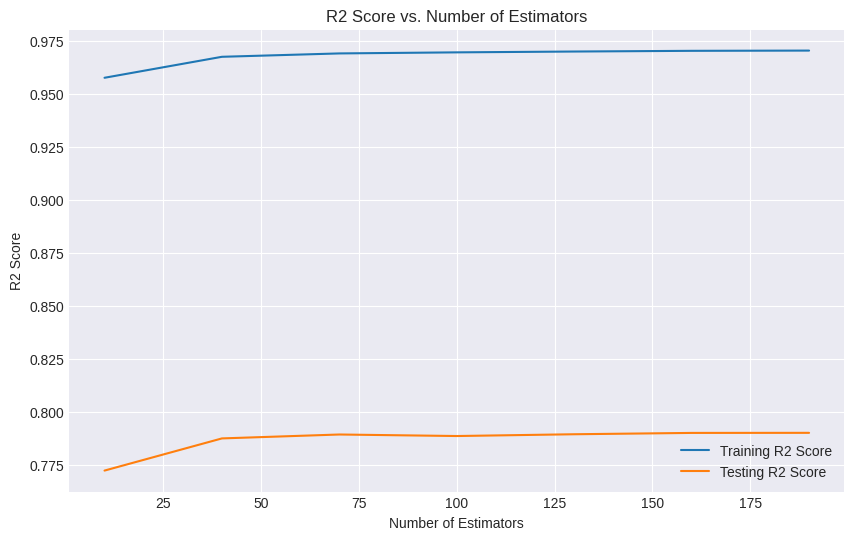

In [76]:
n_r2score_plot(range(10,201,30),1,X_train_XGB_selected,X_test_XGB_selected,y_train,y_test)

In [77]:
# Set the parameter grid to search
param_grid = {
    'n_estimators': [110,150,200,300],
#     'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
}
best_rf_rf = grid_tune(param_grid, 1, 1, X_train_XGB_selected,y_train)
scores(X_train_XGB_selected,X_test_XGB_selected,y_train,y_test,best_rf_rf)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'min_samples_split': 2, 'n_estimators': 300}
Best R2 Score:  0.780884110913756
Train R2 score: 0.9705567050634717, Test R2 score 0.7901547461051955
Train MSE: 0.018314180821909196, Test MSE: 0.1357780740178466
Train RMSE: 0.1353298962606164, Test RMSE: 0.368480764786775
Train MAPE: 0.01875769510312405, Test MAPE: 0.05271576233546062


## feature selection-PCA

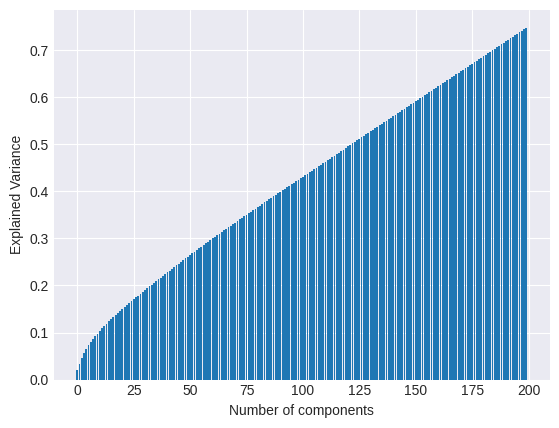

In [78]:
#plot explained variance over the number of compinents
# try to find a best component num
pca = PCA(X.shape[1])
X_S=pca.fit_transform(X)
eigenvalues = pca.explained_variance_ratio_
n= 200
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [79]:
bestPCA = PCA(106)
X_PCA_S_after=bestPCA.fit_transform(X)
X_PCA_S_after.shape

(18042, 106)

In [80]:
components = pd.DataFrame(bestPCA.components_,columns=X.columns)
top_features = components.abs().idxmax(axis=1)

In [81]:
print(top_features)

0                             cheap_room_type
1                           reviews_per_month
2                 property_type_Room in hotel
3                                    bedrooms
4                       room_type_Shared room
                        ...                  
101    neighbourhood_cleansed_Mariners Harbor
102        neighbourhood_cleansed_Willowbrook
103     neighbourhood_cleansed_Brighton Beach
104     neighbourhood_cleansed_Pelham Gardens
105            neighbourhood_cleansed_Concord
Length: 106, dtype: object


In [82]:
X_train_PCA_selected, X_test_PCA_selected, y_train, y_test = train_test_split(X_PCA_S_after, y, test_size=0.2, random_state=99)

### model-XGBoost

In [83]:
xg_reg_pca_features = xgb.XGBRegressor(random_state=42)
xg_reg_pca_features.fit(X_train_PCA_selected, y_train)
scores(X_train_PCA_selected,X_test_PCA_selected,y_train,y_test,xg_reg_pca_features)

Train R2 score: 0.9526924614344556, Test R2 score 0.7501947440045591
Train MSE: 0.029426014221456572, Test MSE: 0.16163375587040557
Train RMSE: 0.171540124231786, Test RMSE: 0.40203700808558107
Train MAPE: 0.026102611366596487, Test MAPE: 0.059233450114762186


In [84]:
n_r2score_plot(range(1,302,50),0,X_train_PCA_selected,X_test_PCA_selected,y_train,y_test)

In [85]:
# Set the parameter grid to search
param_grid = {
    'n_estimators': [50,100,200,300],
#     'min_child_weight':range(2,6),
    'reg_alpha': [0.001, 0.01, 0.1, 1],
    'reg_lambda': [0.001, 0.01, 0.1, 1]
}
best_pca_XGB = grid_tune(param_grid, 0, 1, X_train_PCA_selected,y_train)
scores(X_train_PCA_selected,X_test_PCA_selected,y_train,y_test,best_pca_XGB)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found:  {'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1}
Best R2 Score:  0.7437908977559682
Train R2 score: 0.9803303055708262, Test R2 score 0.7581574279631121
Train MSE: 0.012234851475154374, Test MSE: 0.15648158839538076
Train RMSE: 0.11061126287659125, Test RMSE: 0.3955775377791069
Train MAPE: 0.016547952220290884, Test MAPE: 0.058230245003422575


### model-RF

In [86]:
pca_rf_features = RandomForestRegressor(random_state=42,n_jobs=-1)
pca_rf_features.fit(X_train_PCA_selected, y_train)

scores(X_train_PCA_selected,X_test_PCA_selected,y_train,y_test,pca_rf_features)

Train R2 score: 0.9645735704883649, Test R2 score 0.7502546713891705
Train MSE: 0.022035782250232297, Test MSE: 0.1615949805123146
Train RMSE: 0.14844454267581647, Test RMSE: 0.40198878157520096
Train MAPE: 0.021258123288549945, Test MAPE: 0.05846110144120888


In [87]:
n_r2score_plot([10,50,100],1,X_train_PCA_selected,X_test_PCA_selected,y_train,y_test)

## Neural Nets
### Part 1: data processing following the previous data cleaning and analysis

In [88]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_PCA_S_after, y, test_size=0.1, random_state=99)

In [89]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=99)

In [90]:
type(X_train)

numpy.ndarray

In [91]:
# another way to fill nan
X_train = np.nan_to_num(X_train, nan=np.nanmean(X_train))
X_val= np.nan_to_num(X_val, nan=np.nanmean(X_val))
X_test = np.nan_to_num(X_test, nan=np.nanmean(X_test))

y_train = np.nan_to_num(y_train, nan=np.nanmean(y_train))
y_val = np.nan_to_num(y_val, nan=np.nanmean(y_val))
y_test = np.nan_to_num(y_test, nan=np.nanmean(y_test))



In [92]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64

# data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [93]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [94]:
type(val_dataset)

torch.utils.data.dataset.TensorDataset

In [95]:
type(test_dataset)

torch.utils.data.dataset.TensorDataset

In [96]:
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)

X_train_tensor shape: torch.Size([13801, 106])
y_train_tensor shape: torch.Size([13801, 1])


In [97]:
print("X_val_tensor shape:", X_val_tensor.shape)
print("y_val_tensor shape:", y_val_tensor.shape)

X_val_tensor shape: torch.Size([2436, 106])
y_val_tensor shape: torch.Size([2436, 1])


In [98]:
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_test_tensor shape: torch.Size([1805, 106])
y_test_tensor shape: torch.Size([1805, 1])


### Part 2: Experiment designs and implementations

### We use 4 models:
### 1. Basic 5 layers
### 2. Basic 5 layers with Dropout
### 3. Basic 5 layers with Batch Normalization
### 4. Advanced with 9 layers

### We first use 4 different combinations of learning rate scedulers and optimizers on Basic 5 Layer. Then we use the best combinations of hyperparameters on the rest 3 different architetures. In conlusion, we have 7 different comparable experiments in the following with train and validation losses, and train and validation accuracies metrics and graphs. We conclude that the 5 basic layer architecture with the first set of hyperparameters is the best model in our experiments with our chosen data to predict airbnb pricing for the next month:

In [99]:
class AirbnbPricePredictor(nn.Module):
    def __init__(self, input_size):
        super(AirbnbPricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

    def predict(self, X):
        print(X.shape)
        self.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.from_numpy(X).float()

            print(X.shape)
            if X.dim() == 1:
                X = X.unsqueeze(0)
                print(X.shape)

            output = self(X)
            output = output.squeeze()
            print(output.shape)
            return output.numpy()

In [100]:
class AirbnbPricePredictorDO(nn.Module):
    def __init__(self, input_size, dropout_prob=0.5):
        super(AirbnbPricePredictorDO, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(dropout_prob)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.from_numpy(X).float()
            if X.dim() == 1:
                X = X.unsqueeze(0)
            output = self(X)
            output = output.squeeze()
            return output.numpy()


In [101]:
class AirbnbPricePredictorBN(nn.Module):
    def __init__(self, input_size):
        super(AirbnbPricePredictorBN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.from_numpy(X).float()
            if X.dim() == 1:
                X = X.unsqueeze(0)
            output = self(X)
            output = output.squeeze()
            return output.numpy()

In [102]:
class AirbnbPricePredictor9Layer(nn.Module):
    def __init__(self, input_size):
        super(AirbnbPricePredictor9Layer, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, 32)
        self.fc9 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fc9(x)
        return x

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.from_numpy(X).float()
            if X.dim() == 1:
                X = X.unsqueeze(0)
            output = self(X)
            output = output.squeeze()
            return output.numpy()

#### NN Experiment 1 :

##### Experiment 1-4 are different sets of hyperparameters with this same basci architecture.

##### This set of the hyperparameters from experiment is the (slight)winner for this basic 5-layer architecture, and we will use this set to test on different architectures later (From Experiment 5, we start to experiment with different architectures)

##### Hyperparameters:
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically L1 Loss (Mean Absolute Error) with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: Learning rate scheduler using StepLR method, with a step size of 50 epochs and a gamma value of 0.1.
- **epochs**: Total number of training epochs set to 100.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

###### Results:

- **Hit almost 82% val acc around epoch 50, where train acc hits 93% around epoch 100**

In [103]:
input_size = X_train_tensor.shape[1]
model = AirbnbPricePredictor(input_size)
criterion = nn.L1Loss(reduction='mean')  # Using L1Loss for Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

epochs = 100
threshold = 0.1  # 10% threshold

In [104]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately

        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels

        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)

    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables

    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels

            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions

    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 2.1564, Val Loss: 0.9220, Training Accuracy: 25.74%, Validation Accuracy: 46.84%
Epoch 2/100, Loss: 0.6986, Val Loss: 0.5574, Training Accuracy: 57.28%, Validation Accuracy: 65.85%
Epoch 3/100, Loss: 0.4628, Val Loss: 0.4232, Training Accuracy: 67.55%, Validation Accuracy: 72.62%
Epoch 4/100, Loss: 0.3848, Val Loss: 0.3899, Training Accuracy: 72.80%, Validation Accuracy: 73.52%
Epoch 5/100, Loss: 0.3495, Val Loss: 0.3667, Training Accuracy: 75.92%, Validation Accuracy: 74.59%
Epoch 6/100, Loss: 0.3335, Val Loss: 0.3714, Training Accuracy: 77.70%, Validation Accuracy: 74.96%
Epoch 7/100, Loss: 0.3217, Val Loss: 0.3498, Training Accuracy: 78.76%, Validation Accuracy: 76.89%
Epoch 8/100, Loss: 0.3115, Val Loss: 0.3418, Training Accuracy: 79.88%, Validation Accuracy: 77.26%
Epoch 9/100, Loss: 0.3032, Val Loss: 0.3333, Training Accuracy: 80.67%, Validation Accuracy: 78.74%
Epoch 10/100, Loss: 0.2988, Val Loss: 0.3395, Training Accuracy: 81.28%, Validation Accuracy: 78.24%

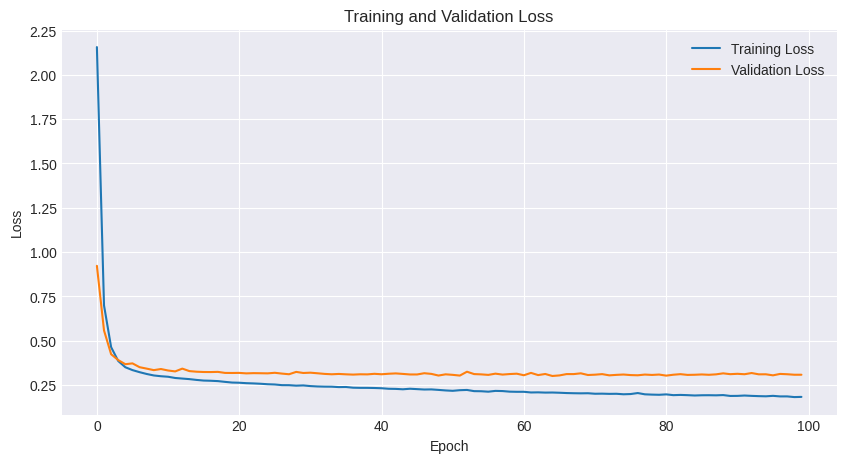

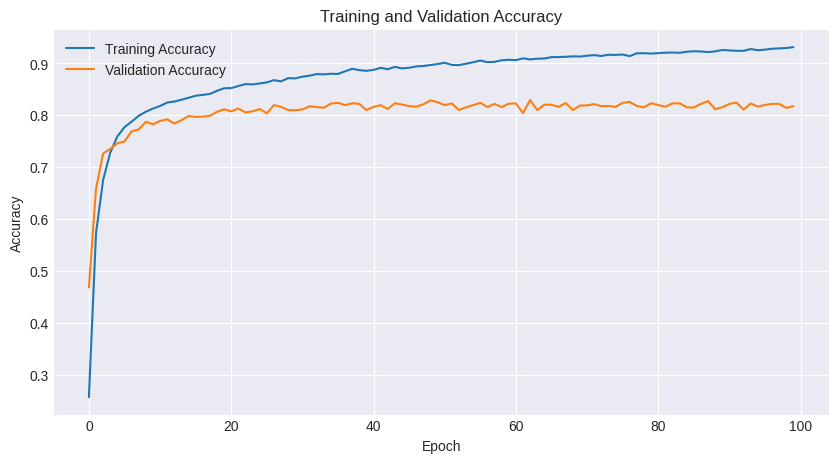

In [105]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### NN Experiment 2:

##### Hyperparameters:
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically nn.MSELoss() with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: No specifict learning rate scheduler set, with the constant 0.0002 lr.
- **epochs**: Total number of training epochs set to 100.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

###### Results:
- **Hit almost 82% val acc around epoch 50, where train acc hits 93% around epoch 100** (Best so far)
- **Hit 80% val acc around epoch 25, where train acc hits 95% around epoch 100, indicating some overfitting** (Currently)

In [106]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor(input_size)

criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.0002)
threshold = 0.1

106


In [107]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately

        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels

        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)

    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables

    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels

            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions

    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 9.0250, Val Loss: 3.6741, Training Accuracy: 9.66%, Validation Accuracy: 22.33%
Epoch 2/100, Loss: 1.8736, Val Loss: 1.7729, Training Accuracy: 34.83%, Validation Accuracy: 49.88%
Epoch 3/100, Loss: 0.6860, Val Loss: 0.8453, Training Accuracy: 52.48%, Validation Accuracy: 59.40%
Epoch 4/100, Loss: 0.3652, Val Loss: 0.5814, Training Accuracy: 63.44%, Validation Accuracy: 68.60%
Epoch 5/100, Loss: 0.2735, Val Loss: 0.4414, Training Accuracy: 69.58%, Validation Accuracy: 71.72%
Epoch 6/100, Loss: 0.2420, Val Loss: 0.4045, Training Accuracy: 72.41%, Validation Accuracy: 72.95%
Epoch 7/100, Loss: 0.2215, Val Loss: 0.3842, Training Accuracy: 74.63%, Validation Accuracy: 74.38%
Epoch 8/100, Loss: 0.2109, Val Loss: 0.3721, Training Accuracy: 75.55%, Validation Accuracy: 74.84%
Epoch 9/100, Loss: 0.1989, Val Loss: 0.3707, Training Accuracy: 76.45%, Validation Accuracy: 73.15%
Epoch 10/100, Loss: 0.1922, Val Loss: 0.3478, Training Accuracy: 77.44%, Validation Accuracy: 77.22%


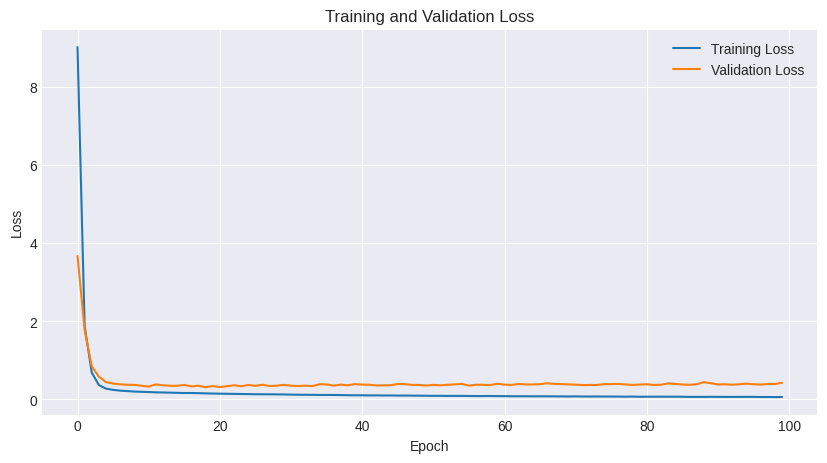

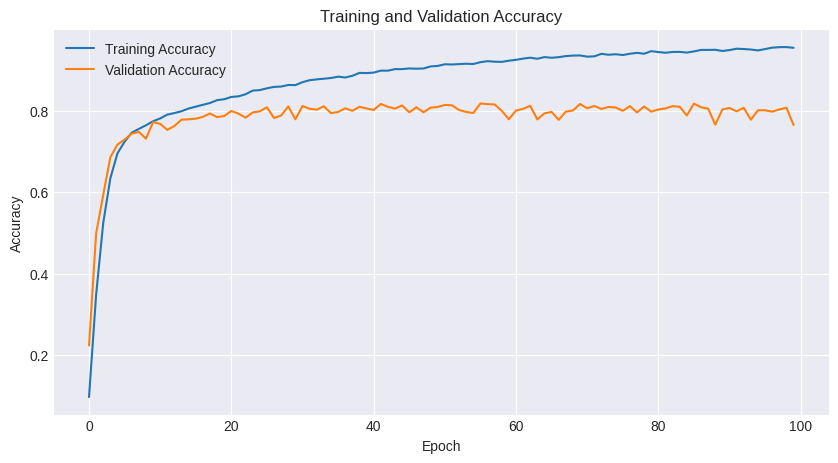

In [108]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### NN Experiment 3:

##### Hyperparameters:
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically nn.L1Loss with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0001.
- **scheduler**: No specifict learning rate scheduler set, with the constant 0.0001 lr.
- **epochs**: Total number of training epochs set to 100.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

###### Results:
- **Hit almost 82% val acc around epoch 50, where train acc hits 93% around epoch 100** (Best so far)
- **Hit 80% val acc around epoch 57, where train acc hits 91% around epoch 100** (Currently)

In [109]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor(input_size)
criterion = nn.L1Loss(reduction='mean')
# criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.0001)
threshold = 0.1

106


In [110]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately

        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels

        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)

    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables

    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels

            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions

    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 3.1844, Val Loss: 1.3344, Training Accuracy: 8.96%, Validation Accuracy: 34.03%
Epoch 2/100, Loss: 1.0348, Val Loss: 0.8744, Training Accuracy: 44.53%, Validation Accuracy: 52.38%
Epoch 3/100, Loss: 0.7531, Val Loss: 0.6905, Training Accuracy: 55.10%, Validation Accuracy: 59.85%
Epoch 4/100, Loss: 0.5892, Val Loss: 0.5397, Training Accuracy: 61.55%, Validation Accuracy: 65.68%
Epoch 5/100, Loss: 0.4654, Val Loss: 0.4480, Training Accuracy: 67.36%, Validation Accuracy: 69.29%
Epoch 6/100, Loss: 0.3976, Val Loss: 0.4090, Training Accuracy: 71.33%, Validation Accuracy: 72.62%
Epoch 7/100, Loss: 0.3653, Val Loss: 0.3880, Training Accuracy: 74.23%, Validation Accuracy: 73.69%
Epoch 8/100, Loss: 0.3477, Val Loss: 0.3753, Training Accuracy: 75.88%, Validation Accuracy: 74.10%
Epoch 9/100, Loss: 0.3376, Val Loss: 0.3661, Training Accuracy: 76.62%, Validation Accuracy: 75.57%
Epoch 10/100, Loss: 0.3260, Val Loss: 0.3618, Training Accuracy: 77.83%, Validation Accuracy: 76.52%


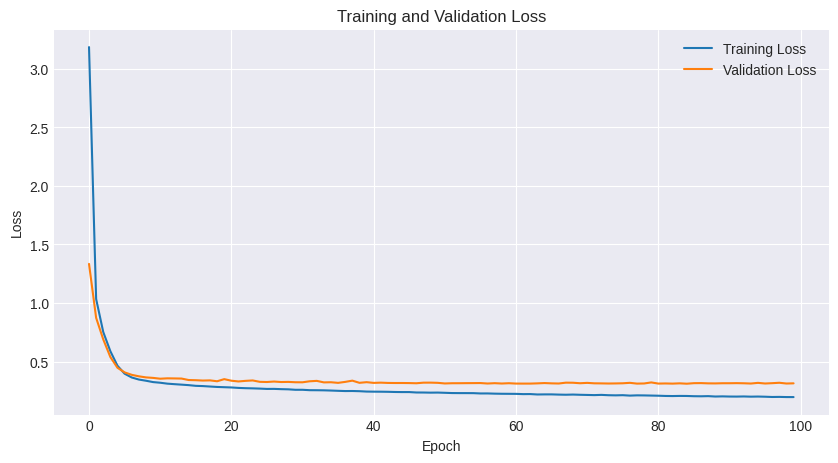

In [111]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### NN Experiment 4:

##### Hyperparameters:
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically nn.L1Loss with reduction method set to mean.
- **optimizer**: SGD optimizer used for model parameter optimization with a learning rate of 0.01 and momentum of 0.9.
- **scheduler**: CyclicLR, with max of 0.01 and base_lr of 0.001.
- **epochs**: Total number of training epochs set to 100.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

###### Results:
- **Hit almost 82% val acc around epoch 50, where train acc hits 93% around epoch 100** (previously best)
- **Hit 83.5% val acc around epoch 70, where train acc hits 93% around epoch 100** (Currently Best)

In [112]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor(input_size)
criterion = nn.L1Loss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# define cyclic learning rate scheduler
step_size_up = 100
step_size_down = 200
base_lr = 0.001
max_lr = 0.01
clr_scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,
                         step_size_up=step_size_up, step_size_down=step_size_down)

106


In [113]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# training
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately

        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels

        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)

    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables

    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels

            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions

    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 2.7073, Val Loss: 0.5909, Training Accuracy: 17.93%, Validation Accuracy: 57.72%
Epoch 2/100, Loss: 0.4435, Val Loss: 0.3764, Training Accuracy: 66.11%, Validation Accuracy: 71.47%
Epoch 3/100, Loss: 0.3699, Val Loss: 0.3471, Training Accuracy: 72.30%, Validation Accuracy: 74.55%
Epoch 4/100, Loss: 0.3492, Val Loss: 0.3344, Training Accuracy: 74.89%, Validation Accuracy: 76.85%
Epoch 5/100, Loss: 0.3367, Val Loss: 0.3326, Training Accuracy: 76.74%, Validation Accuracy: 77.55%
Epoch 6/100, Loss: 0.3286, Val Loss: 0.3192, Training Accuracy: 77.49%, Validation Accuracy: 78.82%
Epoch 7/100, Loss: 0.3191, Val Loss: 0.3138, Training Accuracy: 78.36%, Validation Accuracy: 79.52%
Epoch 8/100, Loss: 0.3148, Val Loss: 0.3090, Training Accuracy: 78.83%, Validation Accuracy: 79.97%
Epoch 9/100, Loss: 0.3078, Val Loss: 0.3107, Training Accuracy: 79.46%, Validation Accuracy: 79.06%
Epoch 10/100, Loss: 0.3020, Val Loss: 0.3043, Training Accuracy: 80.06%, Validation Accuracy: 79.68%

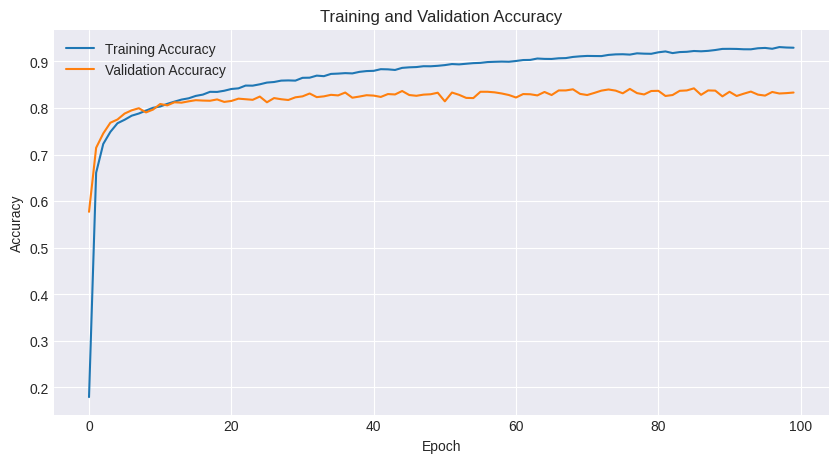

In [114]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### NN Experiment 5: （Different Architecture 5-layer with Dropout)
##### Hyperparameters:
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically L1 Loss (Mean Absolute Error) with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: Learning rate scheduler using StepLR method, with a step size of 50 epochs and a gamma value of 0.1.
- **epochs**: Total number of training epochs set to 200.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

###### Results:

- **Hit 82% val acc around epoch 50, where train acc hits 91% around epoch 54** （without Dropout)
- **Hit 81% val acc around epoch 55, where train acc hits 93% around epoch 100**  (Currently with Dropout)
###### We can see a slightly worse val acc due to the regularization technique here.



In [115]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor(input_size)
criterion = nn.L1Loss(reduction='mean')  # Using L1Loss for Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

epochs = 200
threshold = 0.1  # 10% threshold

106


In [116]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately

        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels

        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)

    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables

    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels

            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions

    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 2.0134, Val Loss: 0.8727, Training Accuracy: 26.60%, Validation Accuracy: 54.23%
Epoch 2/100, Loss: 0.6542, Val Loss: 0.5128, Training Accuracy: 59.01%, Validation Accuracy: 66.54%
Epoch 3/100, Loss: 0.4359, Val Loss: 0.4155, Training Accuracy: 68.13%, Validation Accuracy: 71.06%
Epoch 4/100, Loss: 0.3717, Val Loss: 0.3855, Training Accuracy: 73.42%, Validation Accuracy: 73.56%
Epoch 5/100, Loss: 0.3434, Val Loss: 0.3687, Training Accuracy: 76.13%, Validation Accuracy: 76.15%
Epoch 6/100, Loss: 0.3284, Val Loss: 0.3620, Training Accuracy: 77.64%, Validation Accuracy: 76.97%
Epoch 7/100, Loss: 0.3171, Val Loss: 0.3664, Training Accuracy: 78.90%, Validation Accuracy: 76.40%
Epoch 8/100, Loss: 0.3074, Val Loss: 0.3413, Training Accuracy: 79.93%, Validation Accuracy: 78.04%
Epoch 9/100, Loss: 0.3037, Val Loss: 0.3438, Training Accuracy: 80.88%, Validation Accuracy: 78.33%
Epoch 10/100, Loss: 0.2982, Val Loss: 0.3515, Training Accuracy: 81.27%, Validation Accuracy: 77.05%

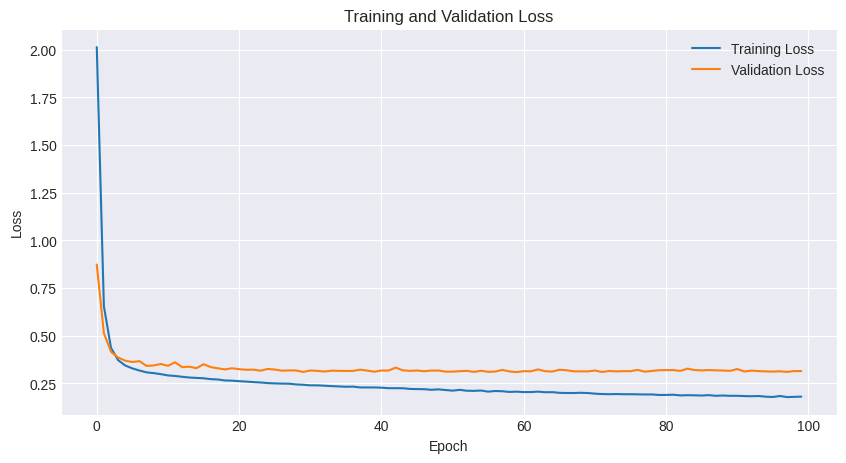

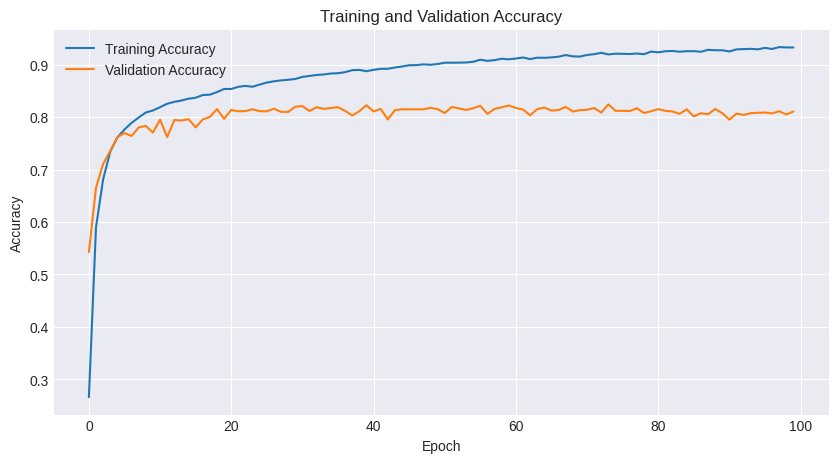

In [117]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### NN Experiment 6: （Different Architecture 5-layer with BatchNormalization)
## Hyperparameters (from the winner of the basci 5-layer architecture):
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically L1 Loss (Mean Absolute Error) with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: Learning rate scheduler using StepLR method, with a step size of 50 epochs and a gamma value of 0.1.
- **epochs**: Total number of training epochs set to 200.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

###### Results:

- **Hit 82% val acc around epoch 50, where train acc hits 91% around epoch 54** （without Dropout)
- **Hit 83% val acc around epoch 60, where train acc hits 91% around epoch 95**  (Currently with BatchNormalization)
###### We can see a slightly worse val and train acc with Batch Normalization.



In [118]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictorBN(input_size)
criterion = nn.L1Loss(reduction='mean')  # Using L1Loss for Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

epochs = 200
threshold = 0.1  # 10% threshold

106


In [119]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately

        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels

        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)

    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables

    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels

            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions

    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 2.7277, Val Loss: 0.6051, Training Accuracy: 11.44%, Validation Accuracy: 52.42%
Epoch 2/100, Loss: 0.4529, Val Loss: 0.3598, Training Accuracy: 62.94%, Validation Accuracy: 75.25%
Epoch 3/100, Loss: 0.3765, Val Loss: 0.3413, Training Accuracy: 71.66%, Validation Accuracy: 77.79%
Epoch 4/100, Loss: 0.3532, Val Loss: 0.3264, Training Accuracy: 75.10%, Validation Accuracy: 78.86%
Epoch 5/100, Loss: 0.3417, Val Loss: 0.3191, Training Accuracy: 75.60%, Validation Accuracy: 79.76%
Epoch 6/100, Loss: 0.3329, Val Loss: 0.3286, Training Accuracy: 77.45%, Validation Accuracy: 79.31%
Epoch 7/100, Loss: 0.3227, Val Loss: 0.3190, Training Accuracy: 78.47%, Validation Accuracy: 80.58%
Epoch 8/100, Loss: 0.3188, Val Loss: 0.3127, Training Accuracy: 79.44%, Validation Accuracy: 80.46%
Epoch 9/100, Loss: 0.3120, Val Loss: 0.3101, Training Accuracy: 79.93%, Validation Accuracy: 80.67%
Epoch 10/100, Loss: 0.3096, Val Loss: 0.3178, Training Accuracy: 80.22%, Validation Accuracy: 79.84%

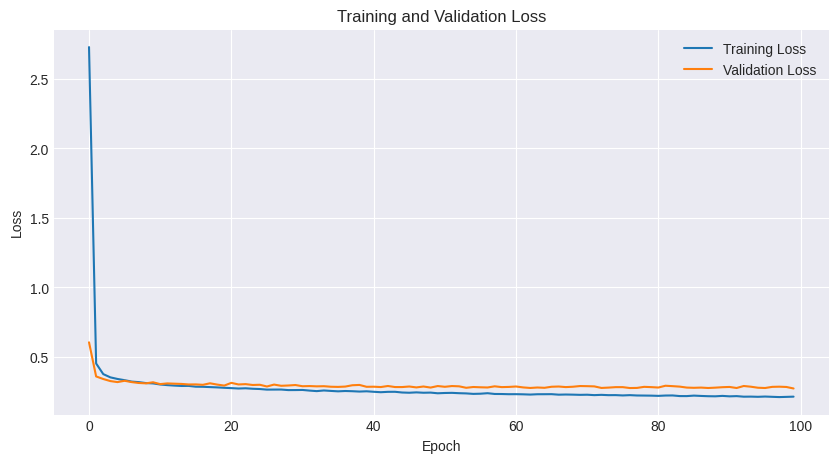

In [120]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### NN Experiment 7: （Different Architecture 9-layer)
##### Hyperparameters (from the winner of the basci 5-layer architecture):
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor9Layers` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically L1 Loss (Mean Absolute Error) with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: Learning rate scheduler using StepLR method, with a step size of 50 epochs and a gamma value of 0.1.
- **epochs**: Total number of training epochs set to 200.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

###### Results:

- **Hit 83.5% val acc around epoch 70, where train acc hits 93% around epoch 100** (The best so far)
- **Hit almost 82% val acc around epoch 98, where train acc hits alsmot 98% around epoch 100**  (Currently with 9 layers)
###### Although with more layers, we can see a much better training accuracy, but we do not see a better val accuracy. This may indicate that overfitting has occurred with this more complex architecture. We also see some unusual val acc fluctuations around epoch 16.


In [121]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor9Layer(input_size)
criterion = nn.L1Loss(reduction='mean')  # Using L1Loss for Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

epochs = 200
threshold = 0.1  # 10% threshold

106


In [122]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately

        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels

        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)

    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables

    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels

            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions

    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 1.5664, Val Loss: 0.6231, Training Accuracy: 35.79%, Validation Accuracy: 54.72%
Epoch 2/100, Loss: 0.4780, Val Loss: 0.4235, Training Accuracy: 64.75%, Validation Accuracy: 69.87%
Epoch 3/100, Loss: 0.3868, Val Loss: 0.4115, Training Accuracy: 71.86%, Validation Accuracy: 70.53%
Epoch 4/100, Loss: 0.3559, Val Loss: 0.3639, Training Accuracy: 75.20%, Validation Accuracy: 77.01%
Epoch 5/100, Loss: 0.3418, Val Loss: 0.3557, Training Accuracy: 76.60%, Validation Accuracy: 77.50%
Epoch 6/100, Loss: 0.3253, Val Loss: 0.3816, Training Accuracy: 78.28%, Validation Accuracy: 74.22%
Epoch 7/100, Loss: 0.3147, Val Loss: 0.3425, Training Accuracy: 79.73%, Validation Accuracy: 79.76%
Epoch 8/100, Loss: 0.3015, Val Loss: 0.3612, Training Accuracy: 81.00%, Validation Accuracy: 76.72%
Epoch 9/100, Loss: 0.3066, Val Loss: 0.3441, Training Accuracy: 80.62%, Validation Accuracy: 79.19%
Epoch 10/100, Loss: 0.2925, Val Loss: 0.3272, Training Accuracy: 81.78%, Validation Accuracy: 80.58%

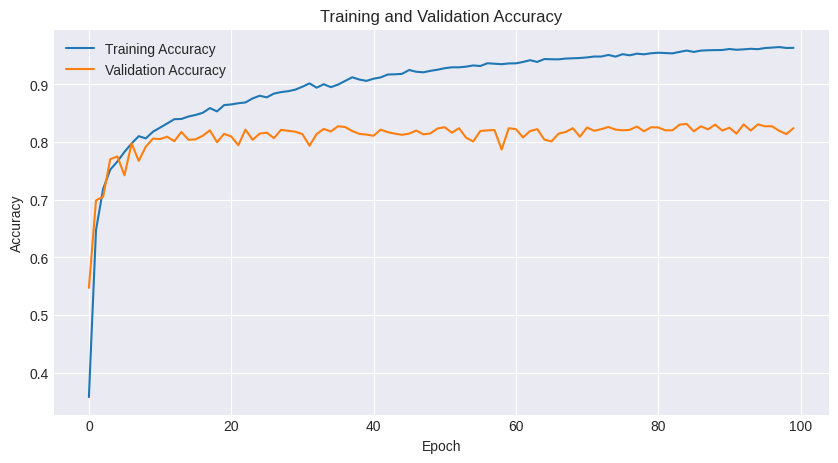

In [123]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### We use the best loss function, optimizer and lr scheduler combination to model from our previous training and validation results (from experiment 4) to model the test set
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size 106.
- **criterion**: Loss function used for optimization, specifically nn.L1Loss with reduction method set to mean.
- **optimizer**: SGD optimizer used for model parameter optimization with a learning rate of 0.01 and momentum of 0.9.
- **scheduler**: CyclicLR, with max of 0.01 and base_lr of 0.001.
- **epochs**: Total number of training epochs set to 100.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

#### Results with test set:
- **Hit 81.5 test acc around epoch 80, 83.5% val acc around epoch 70, where train acc hits almost 93% around epoch 100** (Currently Best)

In [124]:
class AirbnbPricePredictor(nn.Module):
    def __init__(self, input_size):
        super(AirbnbPricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

    def predict(self, X):
        print(X.shape)
        self.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.from_numpy(X).float()

            print(X.shape)
            if X.dim() == 1:
                X = X.unsqueeze(0)
                print(X.shape)

            output = self(X)
            output = output.squeeze()
            print(output.shape)
            return output.numpy()

In [125]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor(input_size)
criterion = nn.L1Loss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# define cyclic learning rate scheduler
step_size_up = 100
step_size_down = 200
base_lr = 0.001
max_lr = 0.01
clr_scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,
                         step_size_up=step_size_up, step_size_down=step_size_down)

106


In [126]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0
    train_total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Input and label NaN checks would be similar to previous snippet

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        abs_percentage_error = torch.abs(outputs - labels) / labels
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)

    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions

    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            abs_percentage_error = torch.abs(outputs - labels) / labels
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions

    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)

    # Test set evaluation
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            abs_percentage_error = torch.abs(outputs - labels) / labels
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)

    epoch_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = correct_predictions / total_predictions

    test_losses.append(epoch_test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}, Test Accuracy: {test_accuracy:.2%}')


Epoch 1/100, Loss: 2.4486, Val Loss: 0.5337, Test Loss: 0.5394, Training Accuracy: 19.43%, Validation Accuracy: 59.44%, Test Accuracy: 58.56%
Epoch 2/100, Loss: 0.4143, Val Loss: 0.3651, Test Loss: 0.3790, Training Accuracy: 68.65%, Validation Accuracy: 71.76%, Test Accuracy: 72.58%
Epoch 3/100, Loss: 0.3625, Val Loss: 0.3462, Test Loss: 0.3608, Training Accuracy: 73.55%, Validation Accuracy: 74.96%, Test Accuracy: 74.90%
Epoch 4/100, Loss: 0.3467, Val Loss: 0.3343, Test Loss: 0.3462, Training Accuracy: 75.15%, Validation Accuracy: 76.31%, Test Accuracy: 77.40%
Epoch 5/100, Loss: 0.3351, Val Loss: 0.3274, Test Loss: 0.3374, Training Accuracy: 76.26%, Validation Accuracy: 77.79%, Test Accuracy: 78.34%
Epoch 6/100, Loss: 0.3276, Val Loss: 0.3239, Test Loss: 0.3334, Training Accuracy: 77.50%, Validation Accuracy: 78.49%, Test Accuracy: 78.78%
Epoch 7/100, Loss: 0.3197, Val Loss: 0.3149, Test Loss: 0.3265, Training Accuracy: 78.30%, Validation Accuracy: 78.78%, Test Accuracy: 78.39%
Epoch 

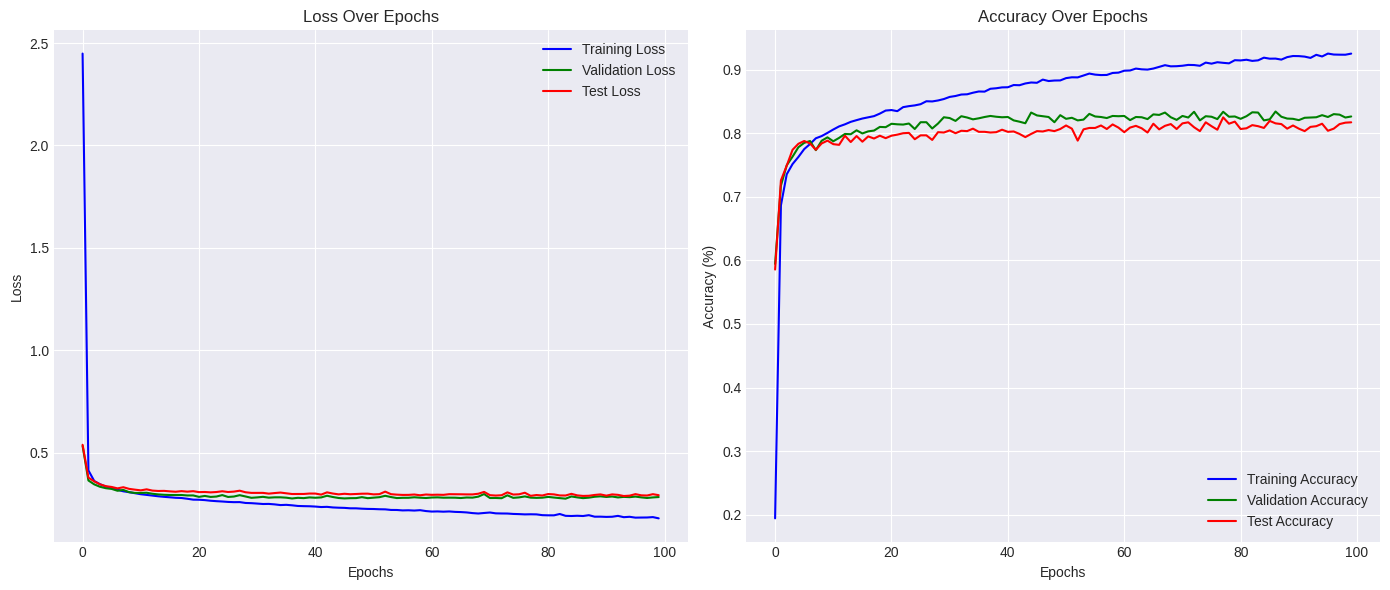

In [127]:
plt.figure(figsize=(14, 6))

# Create subplot for loss
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.plot(test_losses, label='Test Loss', color='red')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Create subplot for accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.plot(test_accuracies, label='Test Accuracy', color='red')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Show the plots
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
plt.show()


In [128]:
from sklearn.metrics import mean_absolute_percentage_error

def scores(X_train, X_test, y_train, y_test, model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # R2
    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    # MSE RMSE - training set
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    # MSE RMSE - testing set
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    # MAPE
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    print(f"Train R2 score: {train_score}, Test R2 score {test_score}")
    print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    print(f"Train MAPE: {train_mape}, Test MAPE: {test_mape}")

# scores(X_train, X_test, y_train, y_test, model)


In [129]:
scores(X_train, X_test, y_train, y_test, model)

(13801, 106)
torch.Size([13801, 106])
torch.Size([13801])
(1805, 106)
torch.Size([1805, 106])
torch.Size([1805])
Train R2 score: 0.8675304133599921, Test R2 score 0.7185452529919076
Train MSE: 0.08293342352340373, Test MSE: 0.18400835591174836
Train RMSE: 0.2879816374760789, Test RMSE: 0.4289619515898215
Train MAPE: 0.036266930260762754, Test MAPE: 0.05942267567593048


# Results

<html xmlns:v="urn:schemas-microsoft-com:vml" xmlns:o="urn:schemas-microsoft-com:office:office" xmlns:x="urn:schemas-microsoft-com:office:excel" xmlns="http://www.w3.org/TR/REC-html40">
 <head>
  <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
  <meta name="ProgId" content="Excel.Sheet">
  <meta name="Generator" content="WPS Office ET">
  <!--[if gte mso 9]>
   <xml>
    <o:DocumentProperties>
     <o:Created>2024-04-30T21:55:47</o:Created>
     <o:LastAuthor>刘大智</o:LastAuthor>
     <o:LastSaved>2024-05-01T11:46:37</o:LastSaved>
    </o:DocumentProperties>
    <o:CustomDocumentProperties>
     <o:ICV dt:dt="string">DC30FCD0EA3341F4933E3F4CFF0F181A_13</o:ICV>
     <o:KSOProductBuildVer dt:dt="string">2052-12.1.0.16364</o:KSOProductBuildVer>
    </o:CustomDocumentProperties>
   </xml>
  <![endif]-->
  <style>
<!-- @page
	{margin:1.00in 0.75in 1.00in 0.75in;
	mso-header-margin:0.50in;
	mso-footer-margin:0.50in;}
tr
	{mso-height-source:auto;
	mso-ruby-visibility:none;}
col
	{mso-width-source:auto;
	mso-ruby-visibility:none;}
br
	{mso-data-placement:same-cell;}
.font0
	{color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:134;}
.font1
	{color:#0000FF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:underline;
	text-underline-style:single;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.font2
	{color:#800080;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:underline;
	text-underline-style:single;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.font3
	{color:#FF0000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.font4
	{color:#44546A;
	font-size:18.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:134;}
.font5
	{color:#7F7F7F;
	font-size:11.0pt;
	font-weight:400;
	font-style:italic;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.font6
	{color:#44546A;
	font-size:15.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:134;}
.font7
	{color:#44546A;
	font-size:13.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:134;}
.font8
	{color:#44546A;
	font-size:11.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:134;}
.font9
	{color:#3F3F76;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.font10
	{color:#3F3F3F;
	font-size:11.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.font11
	{color:#FA7D00;
	font-size:11.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.font12
	{color:#FFFFFF;
	font-size:11.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.font13
	{color:#FA7D00;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.font14
	{color:#000000;
	font-size:11.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.font15
	{color:#006100;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.font16
	{color:#9C0006;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.font17
	{color:#9C6500;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.font18
	{color:#FFFFFF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.font19
	{color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"宋体";
	mso-generic-font-family:auto;
	mso-font-charset:0;}
.style0
	{mso-number-format:"General";
	text-align:general;
	vertical-align:middle;
	white-space:nowrap;
	mso-rotate:0;
	mso-pattern:auto;
	mso-background-source:auto;
	color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:134;
	border:none;
	mso-protection:locked visible;
	mso-style-name:"常规";
	mso-style-id:0;}
.style16
	{mso-number-format:"_ * \#\,\#\#0\.00_ \;_ * \\-\#\,\#\#0\.00_ \;_ * \0022-\0022??_ \;_ \@_ ";
	mso-style-name:"千位分隔";
	mso-style-id:3;}
.style17
	{mso-number-format:"_ \0022\00A5\0022* \#\,\#\#0\.00_ \;_ \0022\00A5\0022* \\-\#\,\#\#0\.00_ \;_ \0022\00A5\0022* \0022-\0022??_ \;_ \@_ ";
	mso-style-name:"货币";
	mso-style-id:4;}
.style18
	{mso-number-format:"0%";
	mso-style-name:"百分比";
	mso-style-id:5;}
.style19
	{mso-number-format:"_ * \#\,\#\#0_ \;_ * \\-\#\,\#\#0_ \;_ * \0022-\0022_ \;_ \@_ ";
	mso-style-name:"千位分隔[0]";
	mso-style-id:6;}
.style20
	{mso-number-format:"_ \0022\00A5\0022* \#\,\#\#0_ \;_ \0022\00A5\0022* \\-\#\,\#\#0_ \;_ \0022\00A5\0022* \0022-\0022_ \;_ \@_ ";
	mso-style-name:"货币[0]";
	mso-style-id:7;}
.style21
	{color:#0000FF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:underline;
	text-underline-style:single;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"超链接";
	mso-style-id:8;}
.style22
	{color:#800080;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:underline;
	text-underline-style:single;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"已访问的超链接";
	mso-style-id:9;}
.style23
	{mso-pattern:auto none;
	background:#FFFFCC;
	border:.5pt solid #B2B2B2;
	mso-style-name:"注释";}
.style24
	{color:#FF0000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"警告文本";}
.style25
	{color:#44546A;
	font-size:18.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:134;
	mso-style-name:"标题";}
.style26
	{color:#7F7F7F;
	font-size:11.0pt;
	font-weight:400;
	font-style:italic;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"解释性文本";}
.style27
	{color:#44546A;
	font-size:15.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:134;
	border-bottom:1.0pt solid #5B9BD5;
	mso-style-name:"标题 1";}
.style28
	{color:#44546A;
	font-size:13.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:134;
	border-bottom:1.0pt solid #5B9BD5;
	mso-style-name:"标题 2";}
.style29
	{color:#44546A;
	font-size:11.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:134;
	border-bottom:1.0pt solid #ACCCEA;
	mso-style-name:"标题 3";}
.style30
	{color:#44546A;
	font-size:11.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:134;
	mso-style-name:"标题 4";}
.style31
	{mso-pattern:auto none;
	background:#FFCC99;
	color:#3F3F76;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	border:.5pt solid #7F7F7F;
	mso-style-name:"输入";}
.style32
	{mso-pattern:auto none;
	background:#F2F2F2;
	color:#3F3F3F;
	font-size:11.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	border:.5pt solid #3F3F3F;
	mso-style-name:"输出";}
.style33
	{mso-pattern:auto none;
	background:#F2F2F2;
	color:#FA7D00;
	font-size:11.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	border:.5pt solid #7F7F7F;
	mso-style-name:"计算";}
.style34
	{mso-pattern:auto none;
	background:#A5A5A5;
	color:#FFFFFF;
	font-size:11.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	border:2.0pt double #3F3F3F;
	mso-style-name:"检查单元格";}
.style35
	{color:#FA7D00;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	border-bottom:2.0pt double #FF8001;
	mso-style-name:"链接单元格";}
.style36
	{color:#000000;
	font-size:11.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	border-top:.5pt solid #5B9BD5;
	border-bottom:2.0pt double #5B9BD5;
	mso-style-name:"汇总";}
.style37
	{mso-pattern:auto none;
	background:#C6EFCE;
	color:#006100;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"好";}
.style38
	{mso-pattern:auto none;
	background:#FFC7CE;
	color:#9C0006;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"差";}
.style39
	{mso-pattern:auto none;
	background:#FFEB9C;
	color:#9C6500;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"适中";}
.style40
	{mso-pattern:auto none;
	background:#5B9BD5;
	color:#FFFFFF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"强调文字颜色 1";}
.style41
	{mso-pattern:auto none;
	background:#DDEBF7;
	color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"20% - 强调文字颜色 1";}
.style42
	{mso-pattern:auto none;
	background:#BDD7EE;
	color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"40% - 强调文字颜色 1";}
.style43
	{mso-pattern:auto none;
	background:#9BC2E6;
	color:#FFFFFF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"60% - 强调文字颜色 1";}
.style44
	{mso-pattern:auto none;
	background:#ED7D31;
	color:#FFFFFF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"强调文字颜色 2";}
.style45
	{mso-pattern:auto none;
	background:#FCE4D6;
	color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"20% - 强调文字颜色 2";}
.style46
	{mso-pattern:auto none;
	background:#F8CBAD;
	color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"40% - 强调文字颜色 2";}
.style47
	{mso-pattern:auto none;
	background:#F4B084;
	color:#FFFFFF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"60% - 强调文字颜色 2";}
.style48
	{mso-pattern:auto none;
	background:#A5A5A5;
	color:#FFFFFF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"强调文字颜色 3";}
.style49
	{mso-pattern:auto none;
	background:#EDEDED;
	color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"20% - 强调文字颜色 3";}
.style50
	{mso-pattern:auto none;
	background:#DBDBDB;
	color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"40% - 强调文字颜色 3";}
.style51
	{mso-pattern:auto none;
	background:#C9C9C9;
	color:#FFFFFF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"60% - 强调文字颜色 3";}
.style52
	{mso-pattern:auto none;
	background:#FFC000;
	color:#FFFFFF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"强调文字颜色 4";}
.style53
	{mso-pattern:auto none;
	background:#FFF2CC;
	color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"20% - 强调文字颜色 4";}
.style54
	{mso-pattern:auto none;
	background:#FFE699;
	color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"40% - 强调文字颜色 4";}
.style55
	{mso-pattern:auto none;
	background:#FFD966;
	color:#FFFFFF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"60% - 强调文字颜色 4";}
.style56
	{mso-pattern:auto none;
	background:#4472C4;
	color:#FFFFFF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"强调文字颜色 5";}
.style57
	{mso-pattern:auto none;
	background:#D9E1F2;
	color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"20% - 强调文字颜色 5";}
.style58
	{mso-pattern:auto none;
	background:#B4C6E7;
	color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"40% - 强调文字颜色 5";}
.style59
	{mso-pattern:auto none;
	background:#8EA9DB;
	color:#FFFFFF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"60% - 强调文字颜色 5";}
.style60
	{mso-pattern:auto none;
	background:#70AD47;
	color:#FFFFFF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"强调文字颜色 6";}
.style61
	{mso-pattern:auto none;
	background:#E2EFDA;
	color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"20% - 强调文字颜色 6";}
.style62
	{mso-pattern:auto none;
	background:#C6E0B4;
	color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"40% - 强调文字颜色 6";}
.style63
	{mso-pattern:auto none;
	background:#A9D08E;
	color:#FFFFFF;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:0;
	mso-style-name:"60% - 强调文字颜色 6";}
td
	{mso-style-parent:style0;
	padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	mso-number-format:"General";
	text-align:general;
	vertical-align:middle;
	white-space:nowrap;
	mso-rotate:0;
	mso-pattern:auto;
	mso-background-source:auto;
	color:#000000;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:宋体;
	mso-generic-font-family:auto;
	mso-font-charset:134;
	border:none;
	mso-protection:locked visible;}
.xl65
	{mso-style-parent:style0;
	text-align:center;
	mso-font-charset:134;
	border-top:1.0pt solid windowtext;
	border-right:1.0pt solid windowtext;
	border-bottom:1.0pt solid windowtext;}
.xl66
	{mso-style-parent:style0;
	text-align:center;
	mso-font-charset:134;
	border:1.0pt solid windowtext;}
.xl67
	{mso-style-parent:style0;
	text-align:center;
	mso-font-charset:134;
	border-right:1.0pt solid windowtext;
	border-bottom:1.0pt solid windowtext;}
.xl68
	{mso-style-parent:style0;
	text-align:center;
	mso-font-charset:134;
	border-left:1.0pt solid windowtext;
	border-right:1.0pt solid windowtext;
	border-bottom:1.0pt solid windowtext;}
.xl69
	{mso-style-parent:style0;
	text-align:center;
	mso-font-charset:134;
	border-right:.5pt solid windowtext;
	border-bottom:.5pt solid windowtext;}
.xl70
	{mso-style-parent:style0;
	text-align:center;
	mso-font-charset:134;
	border-left:.5pt solid windowtext;
	border-right:.5pt solid windowtext;
	border-bottom:.5pt solid windowtext;}
.xl71
	{mso-style-parent:style0;
	text-align:center;
	mso-font-charset:134;
	border-top:.5pt solid windowtext;
	border-right:.5pt solid windowtext;
	border-bottom:.5pt solid windowtext;}
.xl72
	{mso-style-parent:style0;
	text-align:center;
	mso-font-charset:134;
	border:.5pt solid windowtext;}
.xl73
	{mso-style-parent:style0;
	mso-number-format:"0\.0000_ ";
	text-align:center;
	mso-font-charset:134;
	border-top:.5pt solid windowtext;
	border-right:.5pt solid windowtext;
	border-bottom:1.0pt solid windowtext;}
.xl74
	{mso-style-parent:style0;
	mso-number-format:"0\.0000_ ";
	text-align:center;
	mso-font-charset:134;
	border-left:.5pt solid windowtext;
	border-top:.5pt solid windowtext;
	border-right:.5pt solid windowtext;
	border-bottom:1.0pt solid windowtext;}
.xl75
	{mso-style-parent:style0;
	text-align:center;
	mso-font-charset:134;
	border-left:1.0pt solid windowtext;
	border-top:1.0pt solid windowtext;
	border-bottom:1.0pt solid windowtext;}
.xl76
	{mso-style-parent:style0;
	text-align:center;
	mso-font-charset:134;
	border-left:.5pt solid windowtext;
	border-bottom:.5pt solid windowtext;}
.xl77
	{mso-style-parent:style0;
	text-align:center;
	mso-font-charset:134;
	border-left:.5pt solid windowtext;
	border-top:.5pt solid windowtext;
	border-bottom:.5pt solid windowtext;}
.xl78
	{mso-style-parent:style0;
	mso-number-format:"0\.0000_ ";
	text-align:center;
	mso-font-charset:134;
	border-left:.5pt solid windowtext;
	border-top:.5pt solid windowtext;
	border-bottom:1.0pt solid windowtext;}
 -->  </style>
  <!--[if gte mso 9]>
   <xml>
    <x:ExcelWorkbook>
     <x:ExcelWorksheets>
      <x:ExcelWorksheet>
       <x:Name>score</x:Name>
       <x:WorksheetOptions>
        <x:DefaultRowHeight>280</x:DefaultRowHeight>
        <x:StandardWidth>2513</x:StandardWidth>
        <x:Selected/>
        <x:Panes>
         <x:Pane>
          <x:Number>3</x:Number>
          <x:ActiveCol>7</x:ActiveCol>
          <x:ActiveRow>16</x:ActiveRow>
          <x:RangeSelection>H17</x:RangeSelection>
         </x:Pane>
        </x:Panes>
        <x:ProtectContents>False</x:ProtectContents>
        <x:ProtectObjects>False</x:ProtectObjects>
        <x:ProtectScenarios>False</x:ProtectScenarios>
        <x:Print>
         <x:PaperSizeIndex>9</x:PaperSizeIndex>
        </x:Print>
       </x:WorksheetOptions>
      </x:ExcelWorksheet>
     </x:ExcelWorksheets>
     <x:ProtectStructure>False</x:ProtectStructure>
     <x:ProtectWindows>False</x:ProtectWindows>
     <x:WindowHeight>12080</x:WindowHeight>
     <x:WindowWidth>24750</x:WindowWidth>
    </x:ExcelWorkbook>
   </xml>
  <![endif]-->
 </head>
 <body link="blue" vlink="purple">
  <table width="1646" border="0" cellpadding="0" cellspacing="0" style='width:823.00pt;border-collapse:collapse;table-layout:fixed;'>
   <col width="319" style='mso-width-source:userset;mso-width-alt:7777;'/>
   <col width="211" style='mso-width-source:userset;mso-width-alt:5144;'/>
   <col width="141" span="5" style='mso-width-source:userset;mso-width-alt:3437;'/>
   <col width="129" style='mso-width-source:userset;mso-width-alt:3145;'/>
   <col width="141" span="2" style='mso-width-source:userset;mso-width-alt:3437;'/>
   <tr height="29.50" style='height:14.75pt;'>
    <td class="xl65" height="59" width="319" rowspan="2" style='height:29.50pt;width:159.50pt;border-right:1.0pt solid windowtext;border-bottom:1.0pt solid windowtext;' x:str>feature selection method</td>
    <td class="xl66" width="211" rowspan="2" style='width:105.50pt;border-right:1.0pt solid windowtext;border-bottom:1.0pt solid windowtext;' x:str>model</td>
    <td class="xl66" width="564" colspan="4" style='width:282.00pt;border-right:1.0pt solid windowtext;border-bottom:1.0pt solid windowtext;' x:str>training</td>
    <td class="xl66" width="552" colspan="4" style='width:276.00pt;border-right:none;border-bottom:1.0pt solid windowtext;' x:str>testing</td>
   </tr>
   <tr height="29.50" style='height:14.75pt;'>
    <td class="xl66" x:str>R2</td>
    <td class="xl66" x:str>MSE</td>
    <td class="xl66" x:str>RMSE</td>
    <td class="xl66" x:str>MAPE</td>
    <td class="xl66" x:str>R2</td>
    <td class="xl66" x:str>MSE</td>
    <td class="xl66" x:str>RMSE</td>
    <td class="xl75" x:str>MAPE</td>
   </tr>
   <tr height="29.50" style='height:14.75pt;'>
    <td class="xl67" height="59" rowspan="2" style='height:29.50pt;border-right:1.0pt solid windowtext;border-bottom:1.0pt solid windowtext;' x:str>None</td>
    <td class="xl68" x:str>Random Forest</td>
    <td class="xl69" x:num>0.9695</td>
    <td class="xl70" x:num>0.019</td>
    <td class="xl70" x:num>0.1378</td>
    <td class="xl70" x:num>0.019</td>
    <td class="xl70" x:num>0.7884</td>
    <td class="xl70" x:num>0.1369</td>
    <td class="xl70" x:num>0.37</td>
    <td class="xl76" x:num>0.0529</td>
   </tr>
   <tr height="29.50" style='height:14.75pt;'>
    <td class="xl66" x:str>XGBoost</td>
    <td class="xl71" x:num>0.9019</td>
    <td class="xl72" x:num>0.061</td>
    <td class="xl72" x:num>0.2471</td>
    <td class="xl72" x:num>0.0371</td>
    <td class="xl72" x:num>0.7953</td>
    <td class="xl72" x:num>0.1325</td>
    <td class="xl72" x:num>0.3639</td>
    <td class="xl77" x:num>0.0536</td>
   </tr>
   <tr height="29.50" style='height:14.75pt;'>
    <td class="xl65" height="59" rowspan="2" style='height:29.50pt;border-right:1.0pt solid windowtext;border-bottom:1.0pt solid windowtext;' x:str>Random Forest</td>
    <td class="xl66" x:str>Random Forest</td>
    <td class="xl71" x:num>0.9705</td>
    <td class="xl72" x:num>0.0184</td>
    <td class="xl72" x:num>0.1356</td>
    <td class="xl72" x:num>0.0188</td>
    <td class="xl72" x:num>0.7901</td>
    <td class="xl72" x:num>0.1358</td>
    <td class="xl72" x:num>0.3686</td>
    <td class="xl77" x:num>0.0528</td>
   </tr>
   <tr height="29.50" style='height:14.75pt;'>
    <td class="xl66" x:str>XGBoost</td>
    <td class="xl71" x:num>0.9592</td>
    <td class="xl72" x:num>0.0254</td>
    <td class="xl72" x:num>0.1594</td>
    <td class="xl72" x:num>0.024</td>
    <td class="xl72" x:num>0.8068</td>
    <td class="xl72" x:num>0.125</td>
    <td class="xl72" x:num>0.3535</td>
    <td class="xl77" x:num>0.0519</td>
   </tr>
   <tr height="29.50" style='height:14.75pt;'>
    <td class="xl65" height="59" rowspan="2" style='height:29.50pt;border-right:1.0pt solid windowtext;border-bottom:1.0pt solid windowtext;' x:str>XGBoost</td>
    <td class="xl66" x:str>Random Forest</td>
    <td class="xl71" x:num>0.9705</td>
    <td class="xl72" x:num>0.0184</td>
    <td class="xl72" x:num>0.1355</td>
    <td class="xl72" x:num>0.0188</td>
    <td class="xl72" x:num>0.7887</td>
    <td class="xl72" x:num>0.1367</td>
    <td class="xl72" x:num>0.3697</td>
    <td class="xl77" x:num>0.0528</td>
   </tr>
   <tr height="29.50" style='height:14.75pt;'>
    <td class="xl66" x:str>XGBoost</td>
    <td class="xl71" x:num>0.9461</td>
    <td class="xl72" x:num>0.0336</td>
    <td class="xl72" x:num>0.1832</td>
    <td class="xl72" x:num>0.0276</td>
    <td class="xl72" x:num>0.8061</td>
    <td class="xl72" x:num>0.1254</td>
    <td class="xl72" x:num>0.3542</td>
    <td class="xl77" x:num>0.0518</td>
   </tr>
   <tr height="29.50" style='height:14.75pt;'>
    <td class="xl65" height="59" rowspan="2" style='height:29.50pt;border-right:1.0pt solid windowtext;border-bottom:1.0pt solid windowtext;' x:str>PCA</td>
    <td class="xl66" x:str>Random Forest</td>
    <td class="xl71" x:num>0.9653</td>
    <td class="xl72" x:num>0.0216</td>
    <td class="xl72" x:num>0.1468</td>
    <td class="xl72" x:num>0.0209</td>
    <td class="xl72" x:num>0.7557</td>
    <td class="xl72" x:num>0.1581</td>
    <td class="xl72" x:num>0.3976</td>
    <td class="xl77" x:num>0.0578</td>
   </tr>
   <tr height="29.50" style='height:14.75pt;'>
    <td class="xl66" x:str>XGBoost</td>
    <td class="xl71" x:num>0.9806</td>
    <td class="xl72" x:num>0.012</td>
    <td class="xl72" x:num>0.1097</td>
    <td class="xl72" x:num>0.0166</td>
    <td class="xl72" x:num>0.7528</td>
    <td class="xl72" x:num>0.1599</td>
    <td class="xl72" x:num>0.3999</td>
    <td class="xl77" x:num>0.0586</td>
   </tr>
   <tr height="29.50" style='height:14.75pt;'>
    <td class="xl65" height="29.50" colspan="2" style='height:14.75pt;border-right:1.0pt solid windowtext;border-bottom:1.0pt solid windowtext;' x:str>Basic 5-layer NN</td>
    <td class="xl73" x:num="0.87494127670405897">0.8749<span style='mso-spacerun:yes;'>&nbsp;</span></td>
    <td class="xl74" x:num="7.8293805600704203e-002">0.0783<span style='mso-spacerun:yes;'>&nbsp;</span></td>
    <td class="xl74" x:num="0.27981030288519398">0.2798<span style='mso-spacerun:yes;'>&nbsp;</span></td>
    <td class="xl74" x:num="3.5986433735971199e-002">0.0360<span style='mso-spacerun:yes;'>&nbsp;</span></td>
    <td class="xl74" x:num="0.711580002213545">0.7116<span style='mso-spacerun:yes;'>&nbsp;</span></td>
    <td class="xl74" x:num="0.18856206963611599">0.1886<span style='mso-spacerun:yes;'>&nbsp;</span></td>
    <td class="xl74" x:num="0.43423734251687301">0.4342<span style='mso-spacerun:yes;'>&nbsp;</span></td>
    <td class="xl78" x:num="6.2380127359016102e-002">0.0624<span style='mso-spacerun:yes;'>&nbsp;</span></td>
   </tr>
   <![if supportMisalignedColumns]>
    <tr width="0" style='display:none;'>
     <td width="319" style='width:160;'></td>
     <td width="211" style='width:106;'></td>
     <td width="141" style='width:71;'></td>
     <td width="129" style='width:65;'></td>
     <td width="141" style='width:71;'></td>
    </tr>
   <![endif]>
  </table>
 </body>
</html>
